In [ ]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import dynamiqs as dq
import jax.numpy as jnp
from scipy.interpolate import RegularGridInterpolator
import cvxpy as cp
from scipy.linalg import sqrtm


ModuleNotFoundError: No module named 'pandas'

## Useful function

In [249]:
def wigner_fct(x, y, data):
    xvec, yvec, W = data

    # Ensure inputs are NumPy arrays
    xvec = np.asarray(xvec)
    yvec = np.asarray(yvec)
    W = np.asarray(W)

    # Create interpolator (lazy init is better in practice but kept inline here)
    interp = RegularGridInterpolator((xvec, yvec), W.T)

    # Interpolation expects array of shape (N, 2)
    point = np.array([[x, y]])

    return float(interp(point))  # Return scalar
    # i = np.where(np.isclose(xvec, x))[0]
    # j = np.where(np.isclose(yvec, y))[0]

    # if len(i) == 0 or len(j) == 0:
    #     raise ValueError(f"Point (x={x}, y={y}) not found in grid.")

    # return W[i[0], j[0]]

def pk(x, y, data):
    return 1/2 * (1 + np.pi/2 * wigner_fct(x, y, data))  # Return scalar

def measurement_operator(alpha, dim, original_dim=None):
    """
    Construct E_alpha for a given displacement alpha.

    If original_dim is provided, returns truncated operator of shape (original_dim, original_dim).
    """
    D = dq.displace(dim, alpha)
    P = dq.parity(dim)
    E = 0.5 * (dq.eye(dim) + D @ P @ dq.dag(D))

    if original_dim is not None and original_dim < dim:
        E = E.data  # unwrap before slicing
        E = E[:original_dim, :original_dim]
    else:
        E = E.data  # always unwrap for CVXPY use
    return E


In [137]:
def loss_cvxpy(rho_tilde, X, Y, data, dim, original_dim=None):
    alpha_k = (X + 1j * Y).ravel()
    points = np.stack([X.ravel(), Y.ravel()], axis=-1)
    target_p_k = np.array([pk(x, y, data) for x, y in points])

    pred_p_k = []
    for alpha in alpha_k:
        E = measurement_operator(alpha, dim, original_dim=original_dim)
        p = cp.real(cp.trace(E @ rho_tilde))
        pred_p_k.append(p)

    pred_p_k = cp.vstack(pred_p_k)
    target_p_k = target_p_k.reshape(-1, 1)

    return cp.sum_squares(pred_p_k - target_p_k) 

def fidelity(rho, rho_tilde):
    sqrt_rho = sqrtm(rho)
    inner = sqrt_rho @ rho_tilde @ sqrt_rho
    sqrt_inner = sqrtm(inner)
    return np.real(np.trace(sqrt_inner))**2


## Generate quantum state, density matrix and W

In [ ]:
def add_noise(W, sigma):
    """
    Add Gaussian noise to the Wigner function.
    """
    noise = np.random.normal(0, sigma, W.shape)
    W_noisy = W + noise
    return W_noisy

def generate_psi(dim, N, state_type, params, noise=False, sigma=1):
    
    x = jnp.linspace(-3, 3, N)
    p = jnp.linspace(-3, 3, N)
    
    if state_type == 'fock':
        n = params
        psi = dq.fock(dim, n)
        rho_true = dq.fock_dm(dim, n)
        x, y, W = dq.wigner(psi, xvec=x, yvec=p)
        if noise:
            W = add_noise(W, sigma)
        data = (x, y, W)
        plt.contourf(x, y, W, levels=100, cmap="RdBu_r")
        plt.colorbar()
        plt.xlabel("x")
        plt.ylabel("p")
        plt.title("Wigner function for fock state")
        plt.show()
        return psi, rho_true, data
    
    if state_type == 'coherent':
        alpha = params
        psi = dq.coherent(dim, alpha)
        rho_true = dq.coherent_dm(dim, alpha)
        x, y, W = dq.wigner(psi, xvec=x, yvec=p)
        if noise:
            W = add_noise(W, sigma) 
        data = (x, y, W)
        plt.contourf(x, y, W, levels=100, cmap="RdBu_r")
        plt.colorbar()
        plt.xlabel("x")
        plt.ylabel("p")
        plt.title("Wigner function for Coherent state")
        plt.show()
        
        return psi, rho_true, data
        
    if state_type[0] == 'cat':
        alpha = params
        rho_alpha = dq.coherent_dm(dim, alpha)
        rho_minus_alpha = dq.coherent_dm(dim, -alpha)

        # Create kets for |α⟩ and |−α⟩
        ket_alpha = dq.coherent(dim, alpha)
        ket_minus_alpha = dq.coherent(dim, -alpha)
        overlap = dq.braket(ket_minus_alpha, ket_alpha)
        
        if state_type[1] == 'even':
            psi_even =  np.sqrt(2)**(-1) * (ket_alpha + ket_minus_alpha)
            rho_cat_even = (rho_alpha + rho_minus_alpha +
                ket_alpha @ ket_minus_alpha.dag() +
                ket_minus_alpha @ ket_alpha.dag())

            rho_cat_even /= (2 * (1 + overlap.real))
            
            x, y, W = dq.wigner(psi_even, xvec=x, yvec=p)
            if noise:
                W = add_noise(W, sigma)
            data = (x, y, W)
            plt.contourf(x, y, W, levels=100, cmap="RdBu_r")
            plt.colorbar()
            plt.xlabel("x")
            plt.ylabel("p")
            plt.title("Wigner function for even cat state")
            plt.show()
            
            return psi_even, rho_cat_even, data
        
        elif state_type[1] == 'odd':
            psi_odd = np.sqrt(2)**(-1) * (ket_alpha - ket_minus_alpha)
            rho_cat_odd = (rho_alpha + rho_minus_alpha -
               ket_alpha @ ket_minus_alpha.dag() -
               ket_minus_alpha @ ket_alpha.dag())
            rho_cat_odd /= (2 * (1 - overlap.real))
        
            x, y, W = dq.wigner(psi_odd, xvec=x, yvec=p)
            if noise:
                W = add_noise(W, sigma)
            data = (x, y, W)
            plt.contourf(x, y, W, levels=100, cmap="RdBu_r")
            plt.colorbar()
            plt.xlabel("x")
            plt.ylabel("p")
            plt.title("Wigner function for odd cat state")
            plt.show()
            
            return psi_odd, rho_cat_odd, data


### Fit the density matrix

We have chosen to work in a fock space of 10, with deflation between -3, 3, 30 linearly spaced points, and an extra dimension of 40. If we increase the number of points to 50, almost everything will go to 99% fidelity. We kept it like this to be able to see the differences.

In [280]:
def fit_dm(data, rho_true, N, dim_ext, dim=10):
    
    # Choose displacement points
    # xmin, xmax = -3, 3
    # ymin, ymax = -3, 3

    # # Number of points per axis
    # #N = 50

    # # Generate grid of (x, y) values
    # x_vals = np.linspace(xmin, xmax, N)
    # y_vals = np.linspace(ymin, ymax, N)
    
    x_vals, y_vals, _ = data

    # Create 2D grid of x and y values
    X, Y = np.meshgrid(x_vals, y_vals, indexing="ij")

    rho = cp.Variable((dim, dim), hermitian=True)
    #rho = 0.5 * (rho + rho.H)

    constraints = [
        rho >> 0,
        cp.trace(rho) == 1,
    ]

    loss_expr = loss_cvxpy(rho, X, Y, data, dim=dim_ext, original_dim=dim)
    problem = cp.Problem(cp.Minimize(loss_expr), constraints)
    problem.solve(solver=cp.SCS)

    print("Optimal value:", problem.value)
    
    if rho_true is not None:
        print("Fidelity:", fidelity(rho_true, rho.value))

        diag_true = np.real(np.diag(rho_true))
        diag_reco = np.real(np.diag(rho.value))

        # Print
        print("True diag:        ", np.round(diag_true, 5))
        print("Reconstructed diag:", np.round(diag_reco, 5))
        
        return fidelity(rho_true, rho.value)
    
    else:
        diag_reco = np.real(np.diag(rho.value))
        print("True diag:        ", np.round(diag_reco, 5))
        

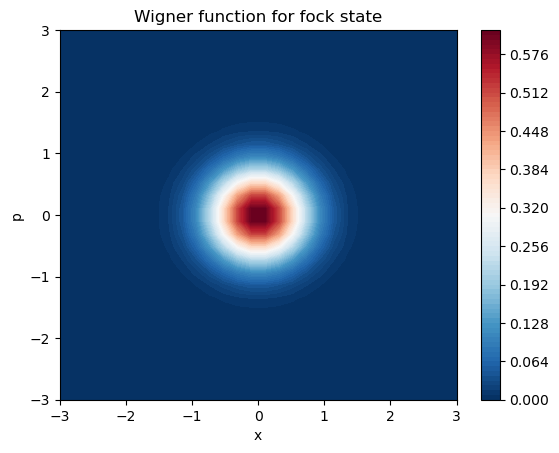

C:\Users\ZenBook\AppData\Local\Temp\ipykernel_9476\1537180879.py:35: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E = 0.5 * (dq.eye(dim) + D @ P @ dq.dag(D))


Optimal value: 4.081745149644388e-08
Fidelity: 0.999915630534781
True diag:         [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Reconstructed diag: [9.9992e-01 2.0000e-05 1.0000e-05 1.0000e-05 1.0000e-05 1.0000e-05
 1.0000e-05 1.0000e-05 0.0000e+00 1.0000e-05]


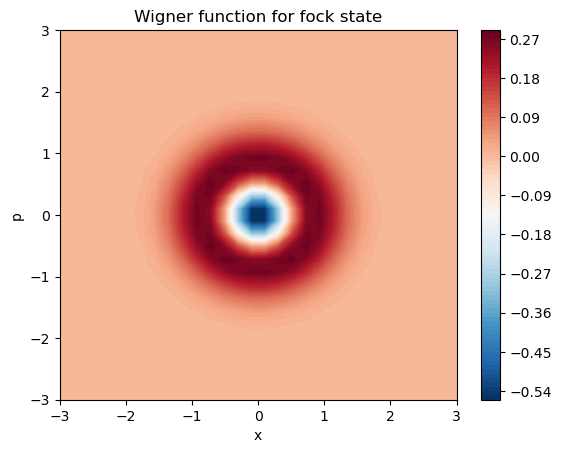

Optimal value: 1.165450425583306e-06
Fidelity: 0.9999403214271091
True diag:         [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Reconstructed diag: [ 1.0000e-05  9.9994e-01  1.0000e-05  1.0000e-05  0.0000e+00 -0.0000e+00
 -0.0000e+00  3.0000e-05  1.0000e-05  0.0000e+00]


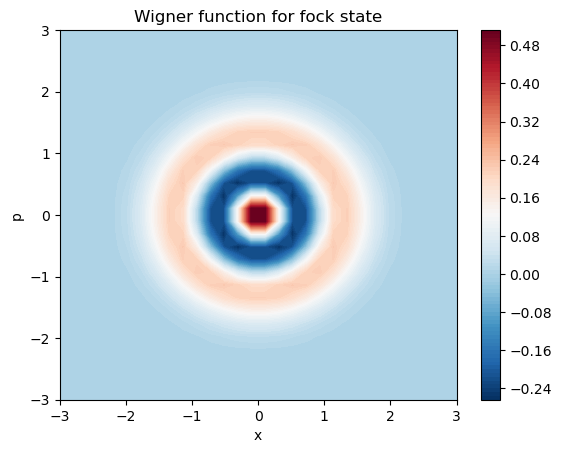

Optimal value: 0.00014374849383598731
Fidelity: 0.9993037348450332
True diag:         [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Reconstructed diag: [-0.000e+00 -2.000e-05  9.993e-01  1.900e-04  6.000e-05 -1.000e-05
 -1.000e-05  3.300e-04  1.600e-04 -1.000e-05]


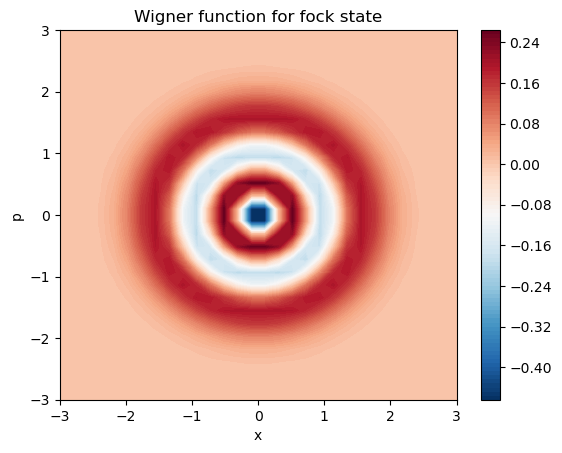

Optimal value: 0.004834335967507637
Fidelity: 0.9964079577624234
True diag:         [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Reconstructed diag: [7.0000e-05 2.8000e-04 0.0000e+00 9.9641e-01 8.3000e-04 1.0000e-05
 0.0000e+00 6.0000e-05 2.2000e-03 1.4000e-04]


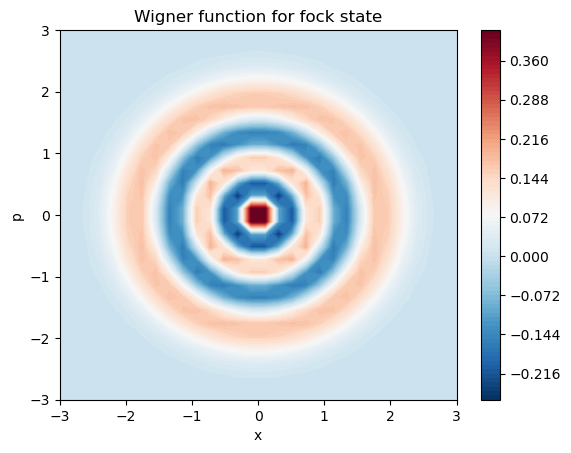

Optimal value: 0.056364738576892254
Fidelity: 0.9802299261416199
True diag:         [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Reconstructed diag: [ 2.2000e-04  2.0600e-03  0.0000e+00  6.1500e-03  9.8023e-01  0.0000e+00
 -0.0000e+00  8.1500e-03  1.9900e-03  1.2000e-03]


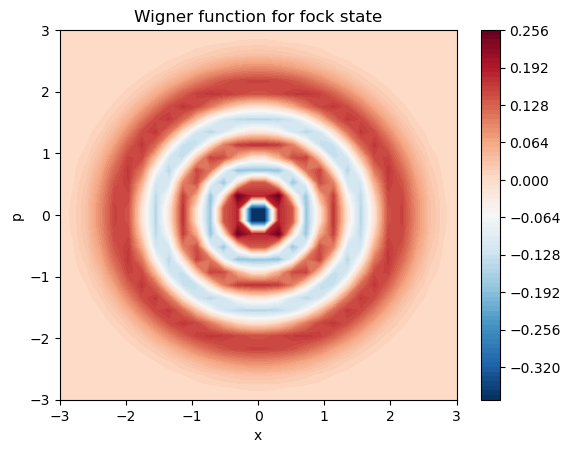

Optimal value: 0.2436813223093272
Fidelity: 0.9302515586545446
True diag:         [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Reconstructed diag: [ 3.2000e-04  4.7100e-03  0.0000e+00  1.0750e-02  1.4210e-02  9.3025e-01
 -0.0000e+00  8.7200e-03  2.6880e-02  4.1800e-03]


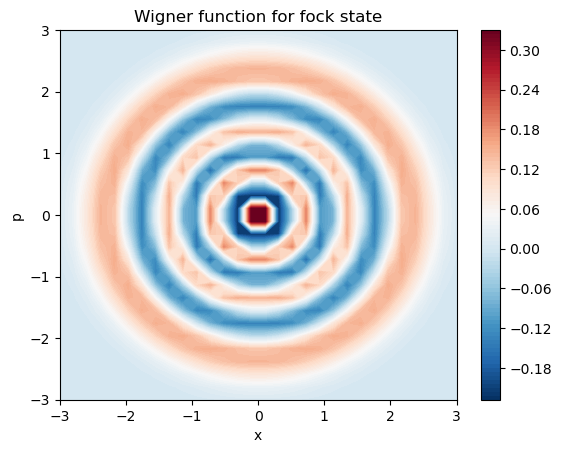

Optimal value: 0.44074251164891626
Fidelity: 0.8883140407568499
True diag:         [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Reconstructed diag: [1.3000e-04 4.0300e-03 2.8000e-04 2.9700e-03 2.6090e-02 1.4160e-02
 8.8831e-01 7.3000e-04 2.7570e-02 3.5720e-02]


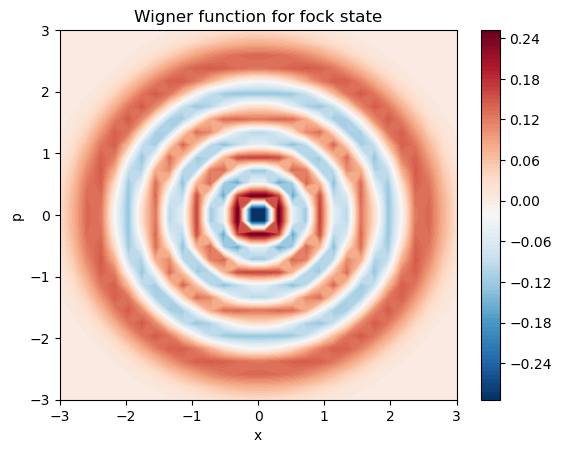

Optimal value: 0.630586003376925
Fidelity: 0.864279334961488
True diag:         [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Reconstructed diag: [1.3000e-04 1.5000e-04 4.2000e-04 1.2700e-03 2.1540e-02 5.0910e-02
 0.0000e+00 8.6428e-01 4.1700e-03 5.7120e-02]


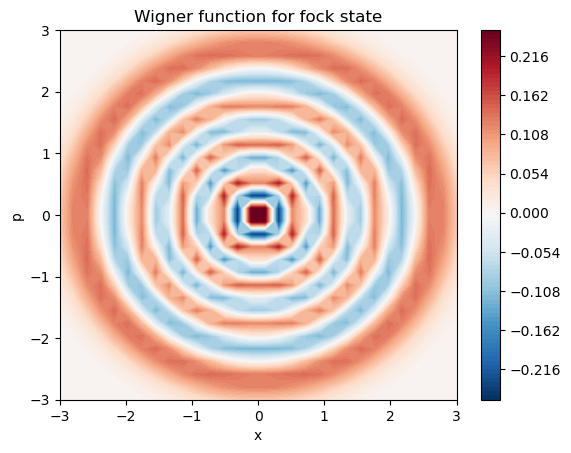

Optimal value: 0.9066475221549526
Fidelity: 0.8301974698359984
True diag:         [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Reconstructed diag: [1.825e-02 1.863e-02 1.846e-02 2.090e-02 2.470e-02 5.142e-02 6.840e-03
 2.700e-04 8.302e-01 1.033e-02]


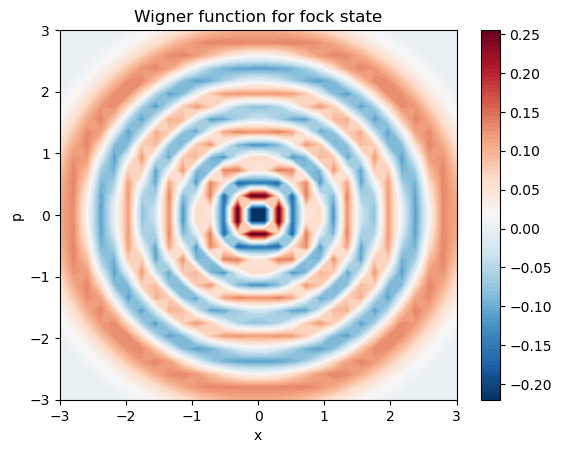

Optimal value: 1.2291376685764415
Fidelity: 0.8141516643407664
True diag:         [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Reconstructed diag: [2.3700e-02 2.3620e-02 2.3210e-02 2.1230e-02 1.7400e-02 1.8200e-02
 3.4270e-02 2.4160e-02 8.0000e-05 8.1415e-01]


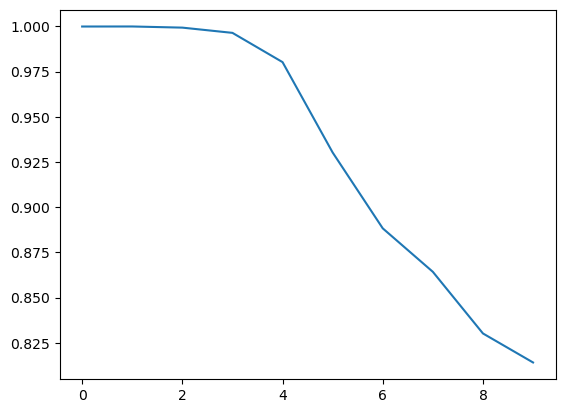

In [149]:
fidelities_fock = []
N = 30
dim = 40

for i in range(10):
    psi, rho_true, data = generate_psi(10, N, 'fock', i)
    fidelity_fock = fit_dm(data, rho_true, N, dim_ext=dim, dim=10)
    fidelities_fock.append(fidelity_fock)
    
plt.plot([i for i in range(10)], fidelities_fock, label='Fock state')

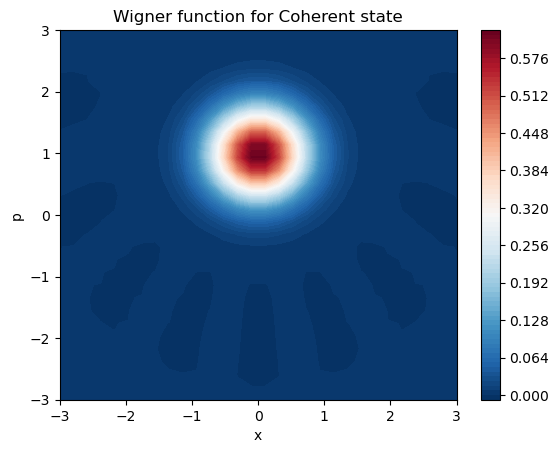

C:\Users\ZenBook\AppData\Local\Temp\ipykernel_9476\1537180879.py:35: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E = 0.5 * (dq.eye(dim) + D @ P @ dq.dag(D))


Optimal value: 1.8012488409433837e-05
Fidelity: 0.9997819539135355
True diag:         [3.6788e-01 3.6788e-01 1.8394e-01 6.1310e-02 1.5330e-02 3.0700e-03
 5.1000e-04 7.0000e-05 1.0000e-05 0.0000e+00]
Reconstructed diag: [ 3.6780e-01  3.6781e-01  1.8389e-01  6.1340e-02  1.5350e-02  3.0600e-03
  5.1000e-04  1.5000e-04  1.0000e-04 -1.0000e-05]


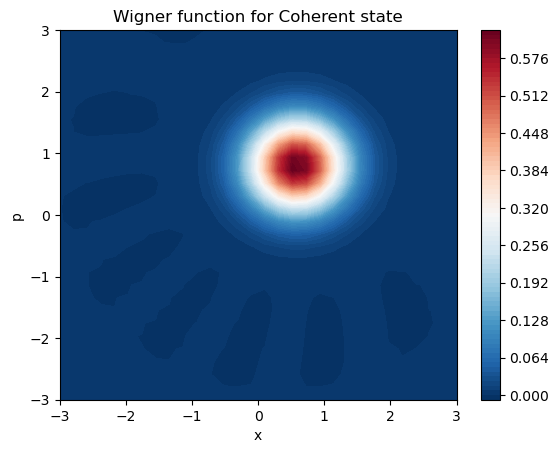

Optimal value: 0.0015736078064840515
Fidelity: 0.9975359171261283
True diag:         [3.6788e-01 3.6788e-01 1.8394e-01 6.1310e-02 1.5330e-02 3.0700e-03
 5.1000e-04 7.0000e-05 1.0000e-05 0.0000e+00]
Reconstructed diag: [3.6735e-01 3.6719e-01 1.8357e-01 6.1410e-02 1.5490e-02 2.9900e-03
 5.8000e-04 5.9000e-04 5.7000e-04 2.5000e-04]


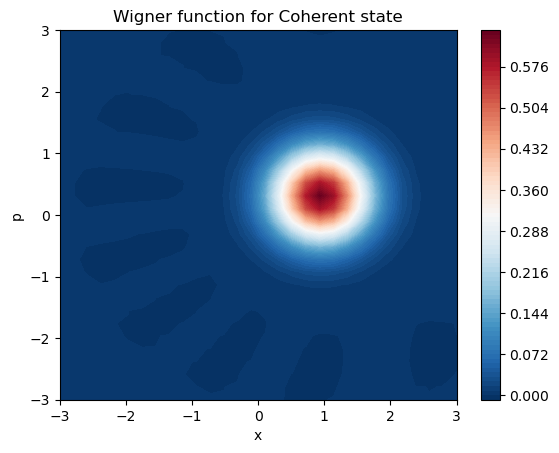

Optimal value: 0.00028229502293568694
Fidelity: 0.998964830370565
True diag:         [3.6788e-01 3.6788e-01 1.8394e-01 6.1310e-02 1.5330e-02 3.0700e-03
 5.1000e-04 7.0000e-05 1.0000e-05 0.0000e+00]
Reconstructed diag: [3.6760e-01 3.6756e-01 1.8379e-01 6.1370e-02 1.5410e-02 3.0500e-03
 5.6000e-04 3.0000e-04 2.5000e-04 1.1000e-04]


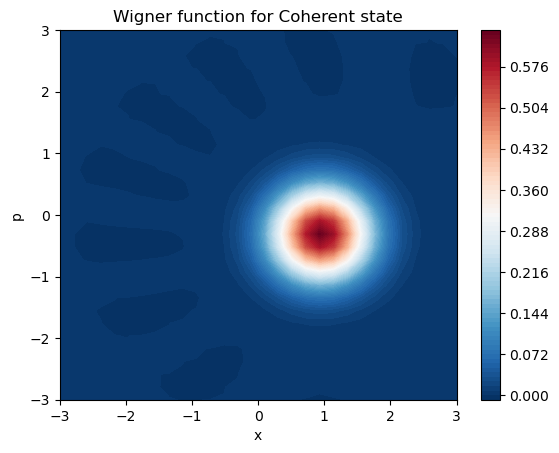

Optimal value: 0.00028229470816126334
Fidelity: 0.998964822681064
True diag:         [3.6788e-01 3.6788e-01 1.8394e-01 6.1310e-02 1.5330e-02 3.0700e-03
 5.1000e-04 7.0000e-05 1.0000e-05 0.0000e+00]
Reconstructed diag: [3.6760e-01 3.6756e-01 1.8379e-01 6.1370e-02 1.5410e-02 3.0500e-03
 5.6000e-04 3.0000e-04 2.5000e-04 1.1000e-04]


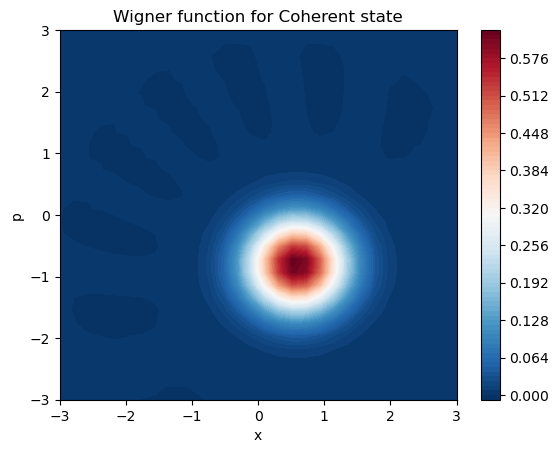

Optimal value: 0.001573606552067842
Fidelity: 0.9975359126190925
True diag:         [3.6788e-01 3.6788e-01 1.8394e-01 6.1310e-02 1.5330e-02 3.0700e-03
 5.1000e-04 7.0000e-05 1.0000e-05 0.0000e+00]
Reconstructed diag: [3.6735e-01 3.6719e-01 1.8357e-01 6.1410e-02 1.5490e-02 2.9900e-03
 5.8000e-04 5.9000e-04 5.7000e-04 2.5000e-04]


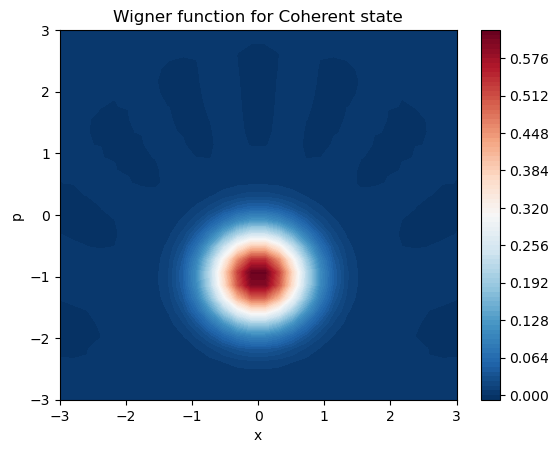

Optimal value: 1.801246767567008e-05
Fidelity: 0.9997819649491345
True diag:         [3.6788e-01 3.6788e-01 1.8394e-01 6.1310e-02 1.5330e-02 3.0700e-03
 5.1000e-04 7.0000e-05 1.0000e-05 0.0000e+00]
Reconstructed diag: [ 3.6780e-01  3.6781e-01  1.8389e-01  6.1340e-02  1.5350e-02  3.0600e-03
  5.1000e-04  1.5000e-04  1.0000e-04 -1.0000e-05]


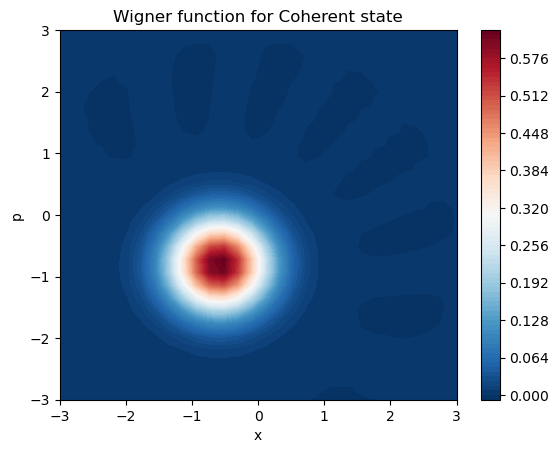

Optimal value: 0.0015736074308404218
Fidelity: 0.9975359308435541
True diag:         [3.6788e-01 3.6788e-01 1.8394e-01 6.1310e-02 1.5330e-02 3.0700e-03
 5.1000e-04 7.0000e-05 1.0000e-05 0.0000e+00]
Reconstructed diag: [3.6735e-01 3.6719e-01 1.8357e-01 6.1410e-02 1.5490e-02 2.9900e-03
 5.8000e-04 5.9000e-04 5.7000e-04 2.5000e-04]


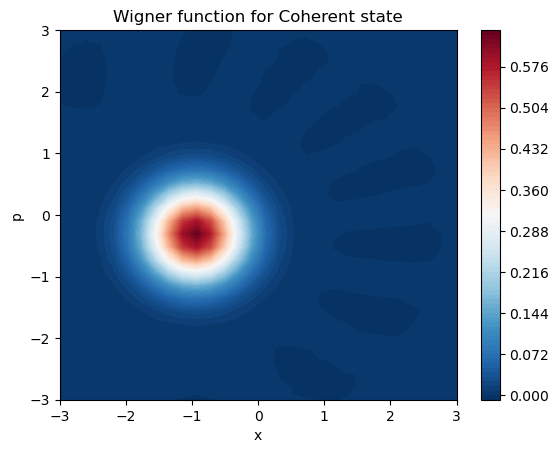

Optimal value: 0.00028229500692438533
Fidelity: 0.9989648393944911
True diag:         [3.6788e-01 3.6788e-01 1.8394e-01 6.1310e-02 1.5330e-02 3.0700e-03
 5.1000e-04 7.0000e-05 1.0000e-05 0.0000e+00]
Reconstructed diag: [3.6760e-01 3.6756e-01 1.8379e-01 6.1370e-02 1.5410e-02 3.0500e-03
 5.6000e-04 3.0000e-04 2.5000e-04 1.1000e-04]


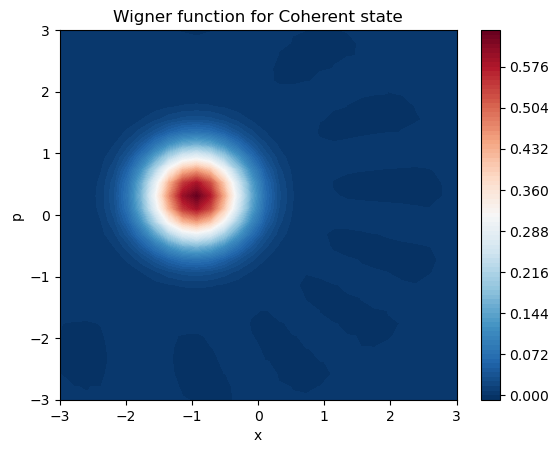

Optimal value: 0.0002822953938217843
Fidelity: 0.998964834276485
True diag:         [3.6788e-01 3.6788e-01 1.8394e-01 6.1310e-02 1.5330e-02 3.0700e-03
 5.1000e-04 7.0000e-05 1.0000e-05 0.0000e+00]
Reconstructed diag: [3.6760e-01 3.6756e-01 1.8379e-01 6.1370e-02 1.5410e-02 3.0500e-03
 5.6000e-04 3.0000e-04 2.5000e-04 1.1000e-04]


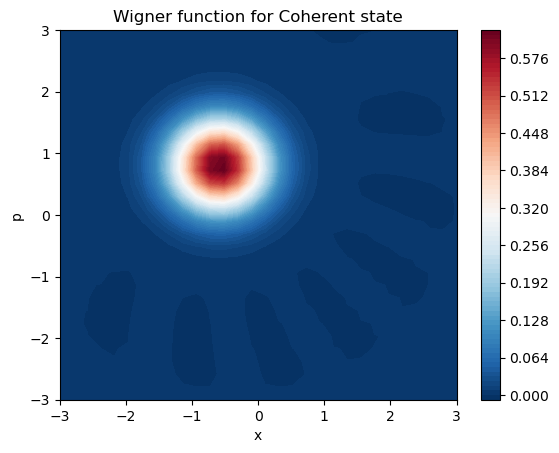

Optimal value: 0.0015736066465068957
Fidelity: 0.9975359142711255
True diag:         [3.6788e-01 3.6788e-01 1.8394e-01 6.1310e-02 1.5330e-02 3.0700e-03
 5.1000e-04 7.0000e-05 1.0000e-05 0.0000e+00]
Reconstructed diag: [3.6735e-01 3.6719e-01 1.8357e-01 6.1410e-02 1.5490e-02 2.9900e-03
 5.8000e-04 5.9000e-04 5.7000e-04 2.5000e-04]


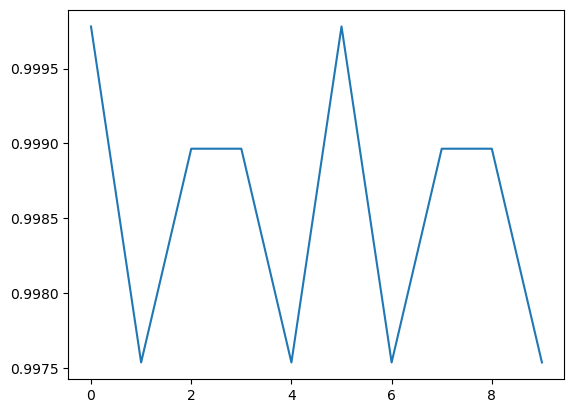

In [154]:
fidelities_coherent = []

n = 10
alphas = [np.exp(2j * np.pi * k / n) for k in range(n)]

for alpha in alphas:
    psi, rho_true, data = generate_psi(10, N, 'coherent', alpha)
    fidelity_coherent = fit_dm(data, rho_true, N, dim_ext=dim, dim=10)
    fidelities_coherent.append(fidelity_coherent)
    
plt.plot([i for i in range(n)], fidelities_coherent, label='Coherent state')

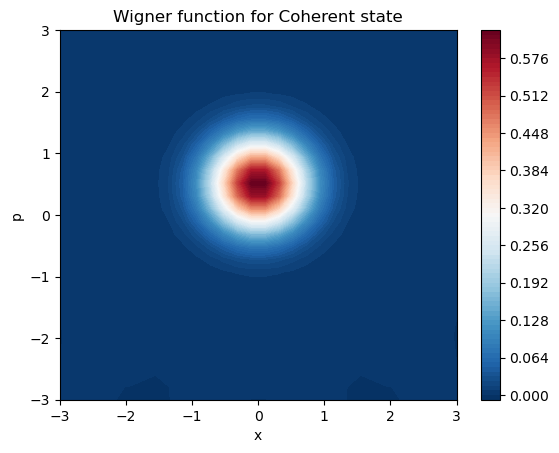

C:\Users\ZenBook\AppData\Local\Temp\ipykernel_9476\1537180879.py:35: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E = 0.5 * (dq.eye(dim) + D @ P @ dq.dag(D))


Optimal value: 4.31303099520524e-07
Fidelity: 0.9999294244712559
True diag:         [7.788e-01 1.947e-01 2.434e-02 2.030e-03 1.300e-04 1.000e-05 0.000e+00
 0.000e+00 0.000e+00 0.000e+00]
Reconstructed diag: [7.7875e-01 1.9470e-01 2.4350e-02 2.0400e-03 1.3000e-04 1.0000e-05
 0.0000e+00 1.0000e-05 1.0000e-05 1.0000e-05]


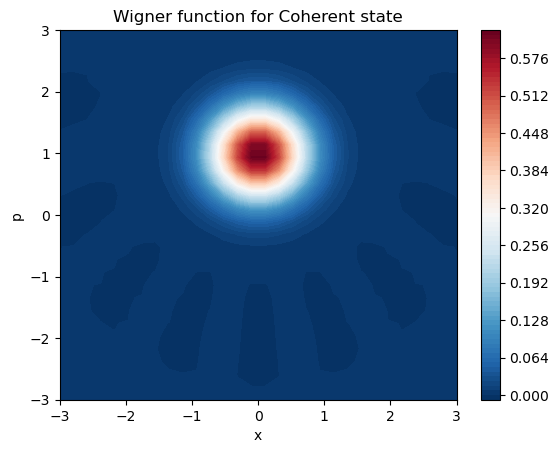

Optimal value: 1.8012488409433837e-05
Fidelity: 0.9997819539135355
True diag:         [3.6788e-01 3.6788e-01 1.8394e-01 6.1310e-02 1.5330e-02 3.0700e-03
 5.1000e-04 7.0000e-05 1.0000e-05 0.0000e+00]
Reconstructed diag: [ 3.6780e-01  3.6781e-01  1.8389e-01  6.1340e-02  1.5350e-02  3.0600e-03
  5.1000e-04  1.5000e-04  1.0000e-04 -1.0000e-05]


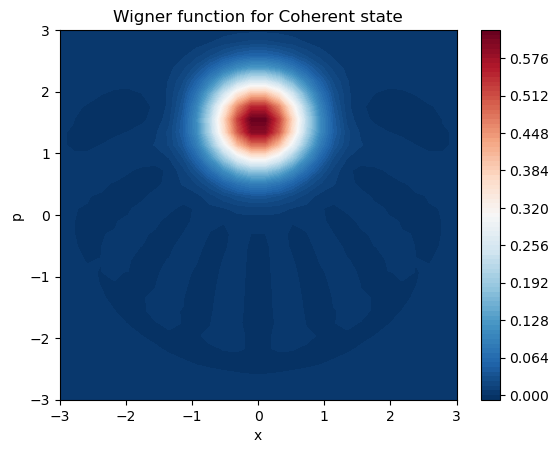

Optimal value: 9.582204332297985e-05
Fidelity: 0.9997451235061118
True diag:         [0.1054  0.23715 0.26679 0.2001  0.11255 0.05067 0.01894 0.0062  0.00158
 0.00063]
Reconstructed diag: [0.10537 0.2371  0.26675 0.20003 0.11244 0.05062 0.01906 0.00644 0.00156
 0.00063]


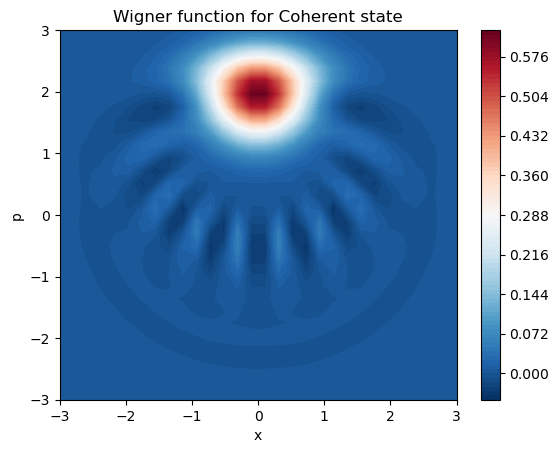

Optimal value: 0.010552903240338191
Fidelity: 0.9934692187139903
True diag:         [0.01832 0.07327 0.1465  0.1955  0.19486 0.15774 0.10101 0.06541 0.02199
 0.02541]
Reconstructed diag: [0.01831 0.0733  0.14648 0.19486 0.19399 0.15862 0.10445 0.06647 0.01975
 0.02377]


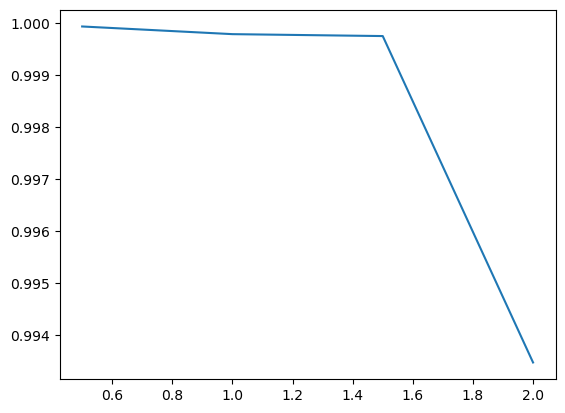

In [173]:
fidelities_coherent_length = []
alphas = [0.5, 1, 1.5, 2]

for alpha in alphas:
    psi, rho_true, data = generate_psi(10, N, 'coherent', alpha)
    fidelity_coherent = fit_dm(data, rho_true, N, dim_ext=dim, dim=10)
    fidelities_coherent_length.append(fidelity_coherent)
    
plt.plot(alphas, fidelities_coherent_length, label='Coherent state')

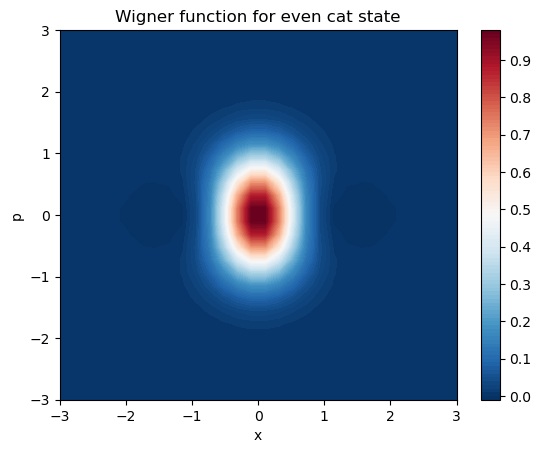

C:\Users\ZenBook\AppData\Local\Temp\ipykernel_9476\1537180879.py:35: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E = 0.5 * (dq.eye(dim) + D @ P @ dq.dag(D))


Optimal value: 1.6874421212422295
Fidelity: 1.0000000324077345
True diag:         [9.6954e-01 0.0000e+00 3.0300e-02 0.0000e+00 1.6000e-04 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
Reconstructed diag: [ 9.6954e-01  0.0000e+00  3.0300e-02  0.0000e+00  1.6000e-04 -0.0000e+00
 -1.0000e-05 -1.0000e-05 -0.0000e+00  1.0000e-05]


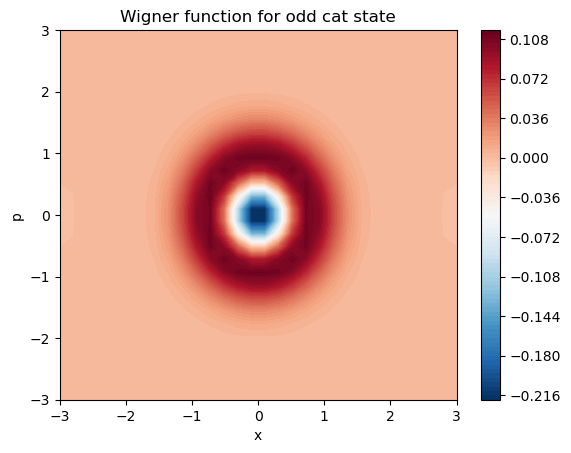

Optimal value: 0.1877819619653172
Fidelity: 0.46095287374934363
True diag:         [0.0000e+00 9.8966e-01 0.0000e+00 1.0310e-02 0.0000e+00 3.0000e-05
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
Reconstructed diag: [0.06749 0.45688 0.06736 0.07074 0.06442 0.0602  0.056   0.05269 0.04874
 0.0555 ]


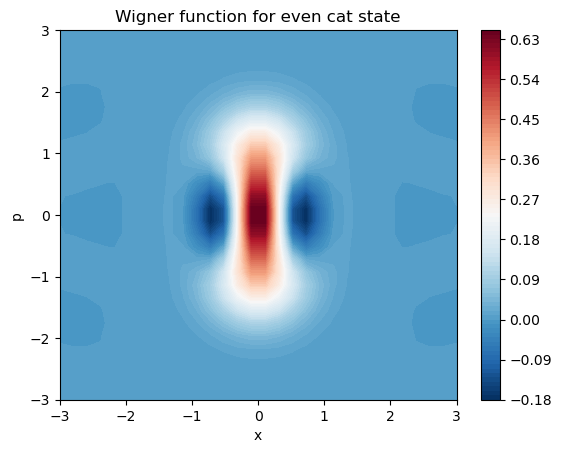

Optimal value: 0.08401743208437909
Fidelity: 1.0000023374469573
True diag:         [6.4805e-01 0.0000e+00 3.2403e-01 0.0000e+00 2.7000e-02 0.0000e+00
 9.0000e-04 0.0000e+00 2.0000e-05 0.0000e+00]
Reconstructed diag: [ 6.4806e-01 -0.0000e+00  3.2403e-01 -0.0000e+00  2.6990e-02 -1.0000e-05
  9.0000e-04  1.0000e-05  2.0000e-05  2.0000e-05]


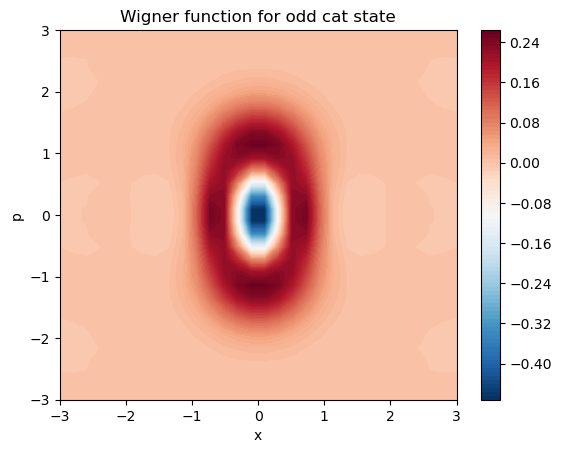

Optimal value: 0.009426200634762644
Fidelity: 0.8797932101452622
True diag:         [0.0000e+00 8.5092e-01 0.0000e+00 1.4182e-01 0.0000e+00 7.0900e-03
 0.0000e+00 1.7000e-04 0.0000e+00 0.0000e+00]
Reconstructed diag: [0.01512 0.75087 0.01508 0.13752 0.0143  0.01938 0.01238 0.01202 0.01098
 0.01233]


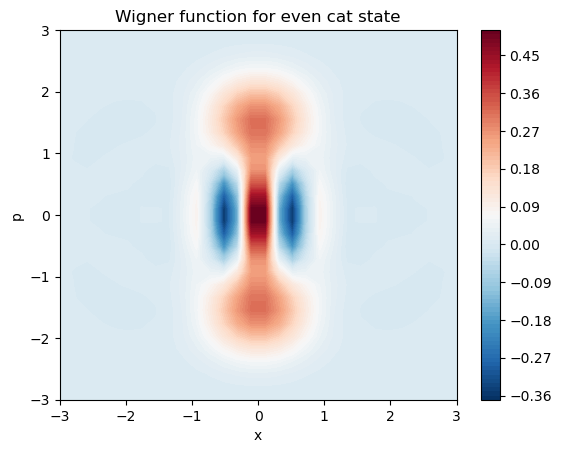

Optimal value: 0.0005783829335697267
Fidelity: 0.9999997213814268
True diag:         [0.20861 0.      0.52803 0.      0.22275 0.      0.03749 0.      0.00312
 0.     ]
Reconstructed diag: [ 0.20861  0.       0.52803  0.       0.22278  0.       0.03748 -0.
  0.00309 -0.     ]


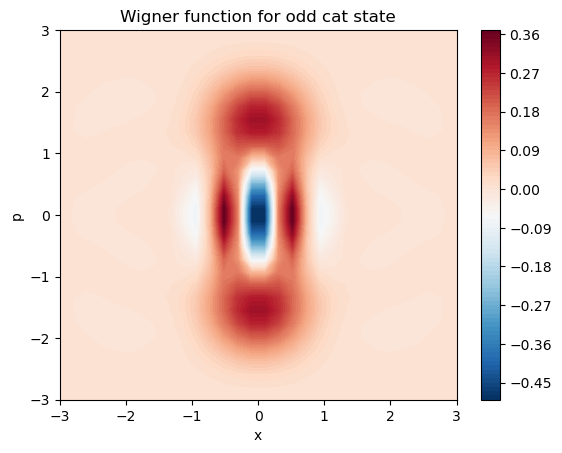

Optimal value: 0.00015674155323837933
Fidelity: 0.9907331758680182
True diag:         [0.      0.47933 0.      0.40444 0.      0.10242 0.      0.01253 0.
 0.00128]
Reconstructed diag: [0.00124 0.47554 0.00122 0.40132 0.00085 0.10196 0.00103 0.01417 0.00116
 0.00151]


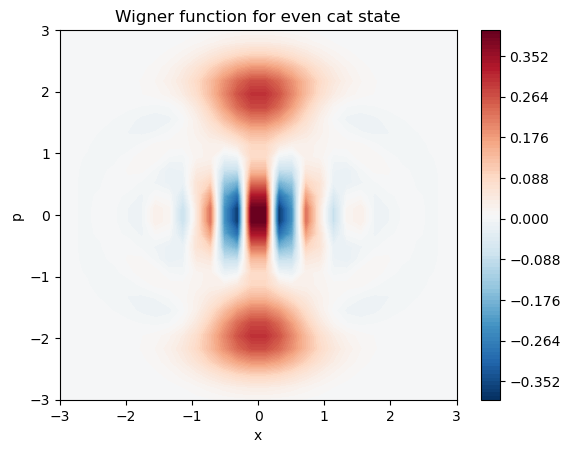

Optimal value: 0.005983569849600342
Fidelity: 0.9679673285991661
True diag:         [0.03795 0.      0.30352 0.      0.40371 0.      0.20927 0.      0.04555
 0.     ]
Reconstructed diag: [0.04049 0.00395 0.29727 0.00458 0.39489 0.00698 0.20711 0.00076 0.04255
 0.00143]


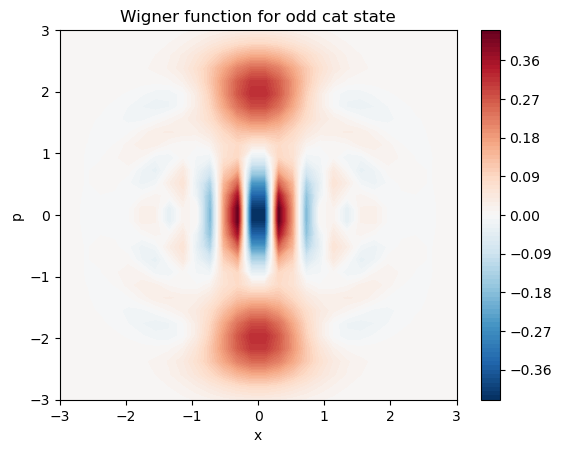

Optimal value: 0.019740174129692985
Fidelity: 0.9998818016869403
True diag:         [0.      0.14162 0.      0.3779  0.      0.30492 0.      0.12643 0.
 0.04913]
Reconstructed diag: [-0.       0.14243 -0.       0.37859 -0.       0.30556 -0.       0.12895
 -0.       0.04448]


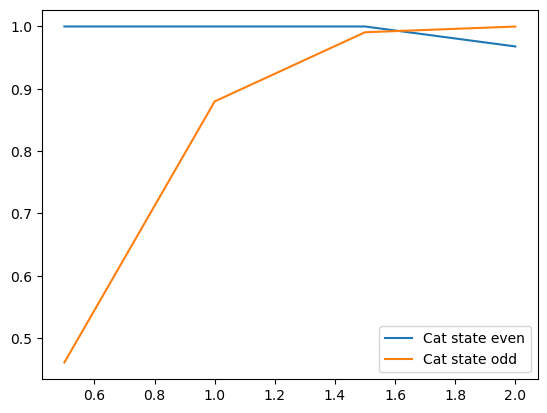

In [174]:
fidelities_cat_even = []
fidelities_cat_odd = []

for alpha in alphas:
    psi, rho_true, data = generate_psi(10, N, ('cat', 'even'), alpha)
    fidelity_cat_even = fit_dm(data, rho_true, N, dim_ext=dim, dim=10)
    fidelities_cat_even.append(fidelity_cat_even)

    psi, rho_true, data = generate_psi(10, N, ('cat', 'odd'), alpha)
    fidelity_cat_odd = fit_dm(data, rho_true, N, dim_ext=dim, dim=10)
    fidelities_cat_odd.append(fidelity_cat_odd)
    
    
plt.plot(alphas, fidelities_cat_even, label='Cat state even')
plt.plot(alphas, fidelities_cat_odd, label='Cat state odd') 
plt.legend()
plt.show()

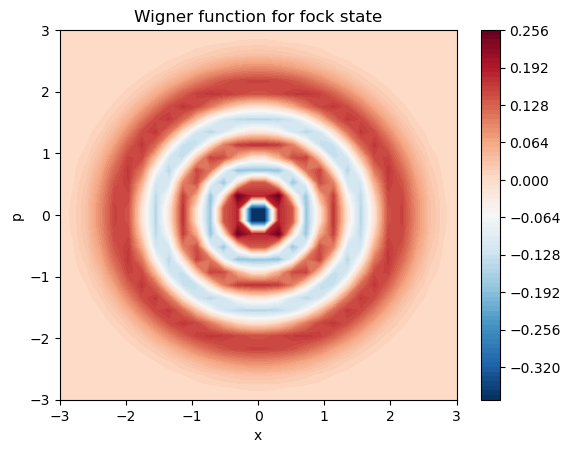

C:\Users\ZenBook\AppData\Local\Temp\ipykernel_9476\1537180879.py:35: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E = 0.5 * (dq.eye(dim) + D @ P @ dq.dag(D))


Optimal value: 0.2436813223093272
Fidelity: 0.9302515586545446
True diag:         [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Reconstructed diag: [ 3.2000e-04  4.7100e-03  0.0000e+00  1.0750e-02  1.4210e-02  9.3025e-01
 -0.0000e+00  8.7200e-03  2.6880e-02  4.1800e-03]


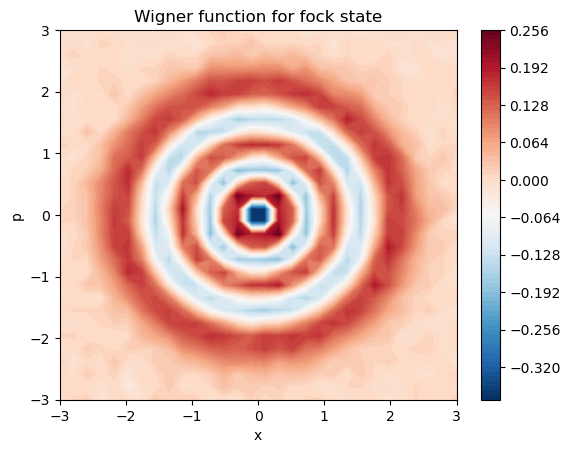

Optimal value: 0.2932643443128201
Fidelity: 0.92678071381453
True diag:         [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Reconstructed diag: [6.0000e-04 5.8800e-03 4.1000e-04 1.0780e-02 1.3400e-02 9.2678e-01
 1.7000e-04 1.0230e-02 2.5220e-02 6.5200e-03]


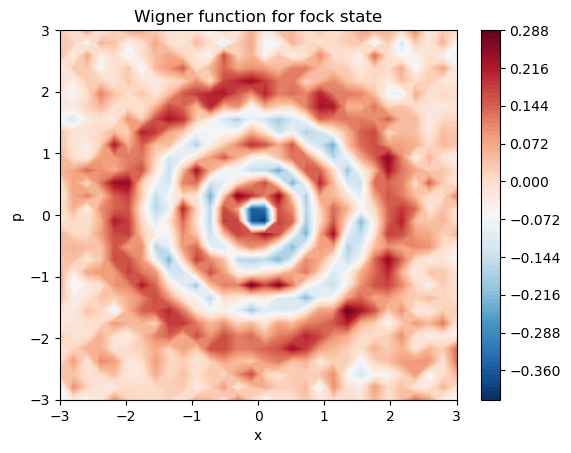

Optimal value: 1.4677115830114953
Fidelity: 0.8838184329867311
True diag:         [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Reconstructed diag: [0.00629 0.00535 0.00619 0.02208 0.03077 0.88382 0.00118 0.00219 0.02637
 0.01575]


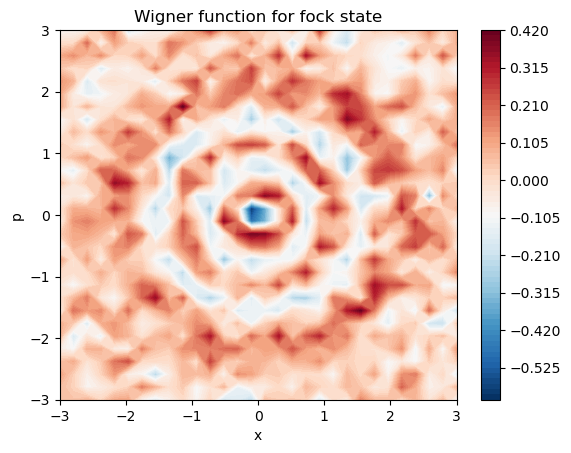

Optimal value: 5.677565714003787
Fidelity: 0.8849234635844706
True diag:         [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Reconstructed diag: [0.01019 0.02756 0.00477 0.01434 0.00706 0.88492 0.00328 0.00608 0.03266
 0.00913]


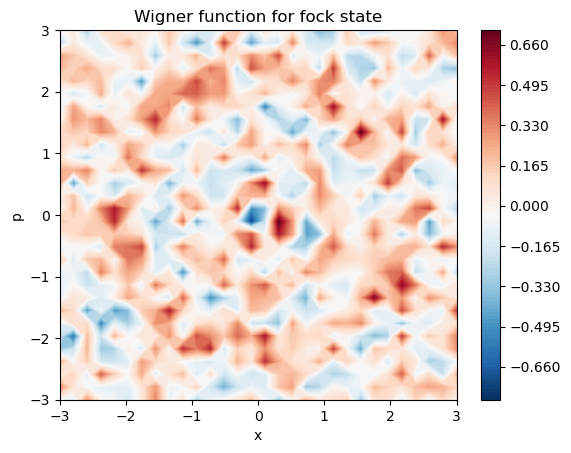

Optimal value: 21.804663576098122
Fidelity: 0.7739090509470669
True diag:         [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Reconstructed diag: [0.01679 0.03462 0.01371 0.05501 0.02606 0.77391 0.02098 0.03307 0.0151
 0.01076]


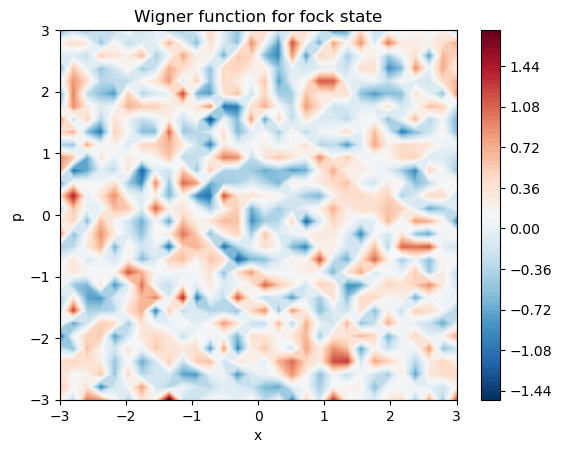

Optimal value: 133.54709685549705
Fidelity: 0.6092370031140079
True diag:         [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Reconstructed diag: [0.00547 0.0257  0.14979 0.01357 0.01931 0.60924 0.0271  0.0764  0.03882
 0.03458]


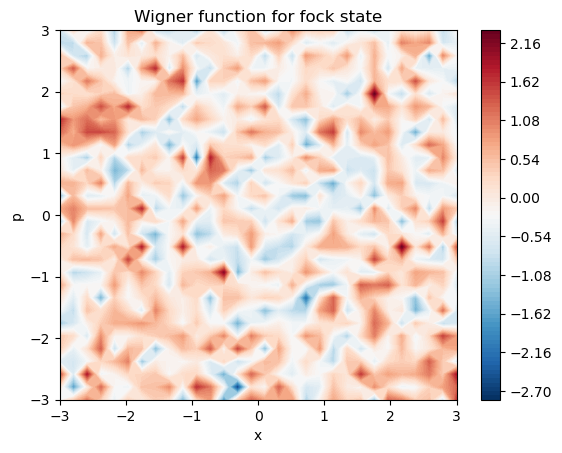

Optimal value: 266.46968346387325
Fidelity: 0.6462443181597942
True diag:         [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Reconstructed diag: [0.00527 0.01565 0.02569 0.02129 0.05232 0.64624 0.07864 0.0593  0.04634
 0.04927]


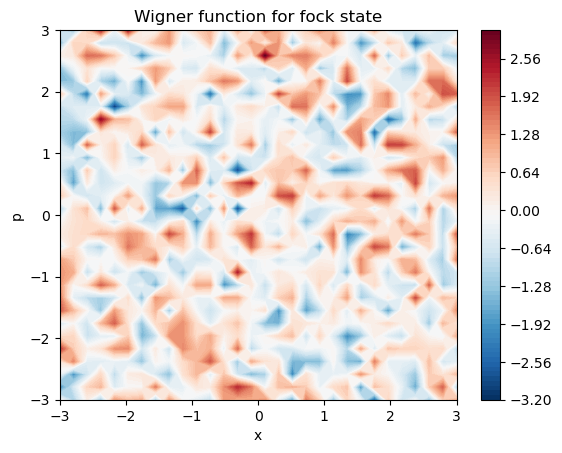

Optimal value: 517.2674069855144
Fidelity: 0.319162962272985
True diag:         [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Reconstructed diag: [0.11321 0.05257 0.04551 0.07017 0.01946 0.31916 0.13001 0.03074 0.1188
 0.10037]


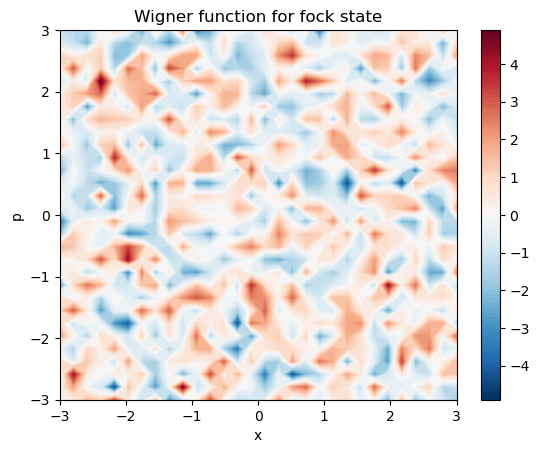

Optimal value: 1276.307576920507
Fidelity: 0.20918294673490662
True diag:         [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Reconstructed diag: [0.06463 0.04632 0.02989 0.27754 0.12774 0.20918 0.0575  0.06195 0.02136
 0.1039 ]


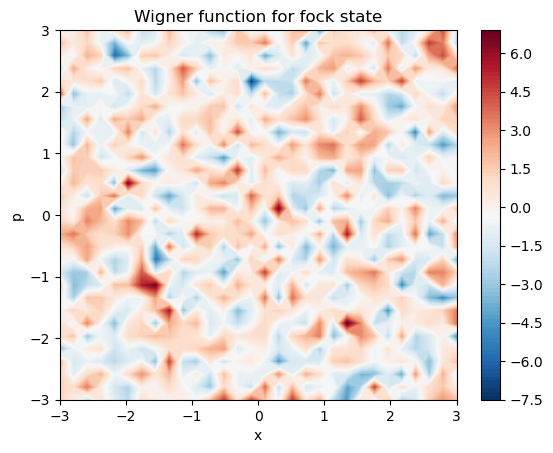

Optimal value: 2268.192950102408
Fidelity: 0.12528482014317566
True diag:         [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Reconstructed diag: [0.04682 0.02998 0.03462 0.10512 0.10884 0.12528 0.18711 0.0301  0.0311
 0.30103]


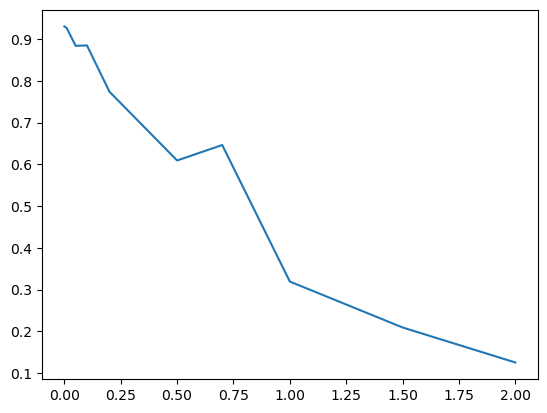

In [170]:
sigmas = [0, 0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 1, 1.5, 2]
fidelities_fock_noise = []

for sigma in sigmas:
    psi, rho_true, data = generate_psi(10, N, 'fock', 5, noise=True, sigma=sigma)
    fidelity_fock = fit_dm(data, rho_true, N, dim_ext=dim, dim=10)
    fidelities_fock_noise.append(fidelity_fock)
    
plt.plot(sigmas, fidelities_fock_noise, label='Fock state with noise')

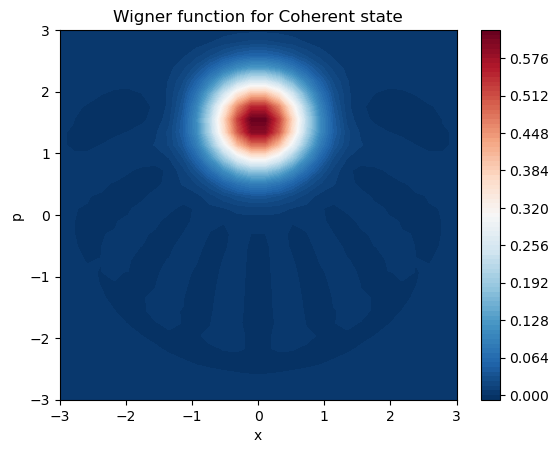

C:\Users\ZenBook\AppData\Local\Temp\ipykernel_9476\1537180879.py:35: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E = 0.5 * (dq.eye(dim) + D @ P @ dq.dag(D))


Optimal value: 9.582204332297985e-05
Fidelity: 0.9997451235061118
True diag:         [0.1054  0.23715 0.26679 0.2001  0.11255 0.05067 0.01894 0.0062  0.00158
 0.00063]
Reconstructed diag: [0.10537 0.2371  0.26675 0.20003 0.11244 0.05062 0.01906 0.00644 0.00156
 0.00063]


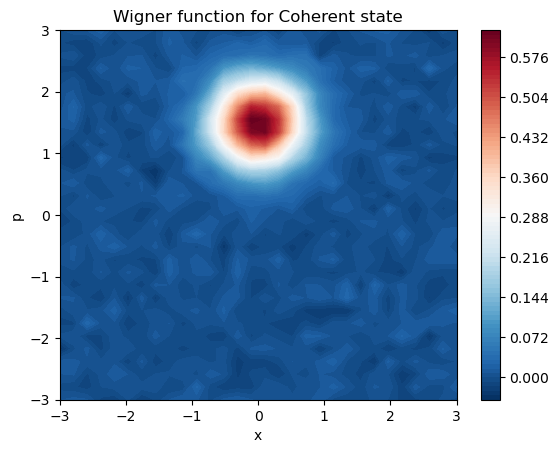

Optimal value: 0.057019643020874096
Fidelity: 0.9911454422506083
True diag:         [0.1054  0.23715 0.26679 0.2001  0.11255 0.05067 0.01894 0.0062  0.00158
 0.00063]
Reconstructed diag: [0.109   0.23523 0.26833 0.19618 0.10938 0.05033 0.0214  0.00637 0.00257
 0.00121]


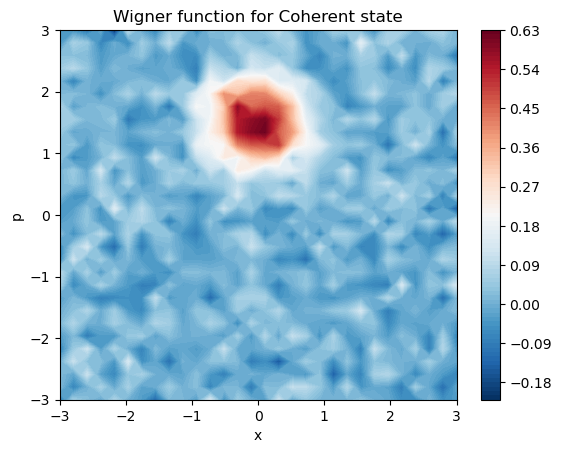

Optimal value: 1.4284994721917348
Fidelity: 0.9339022986182814
True diag:         [0.1054  0.23715 0.26679 0.2001  0.11255 0.05067 0.01894 0.0062  0.00158
 0.00063]
Reconstructed diag: [0.09626 0.23292 0.25879 0.20572 0.09828 0.05405 0.03271 0.00857 0.00549
 0.0072 ]


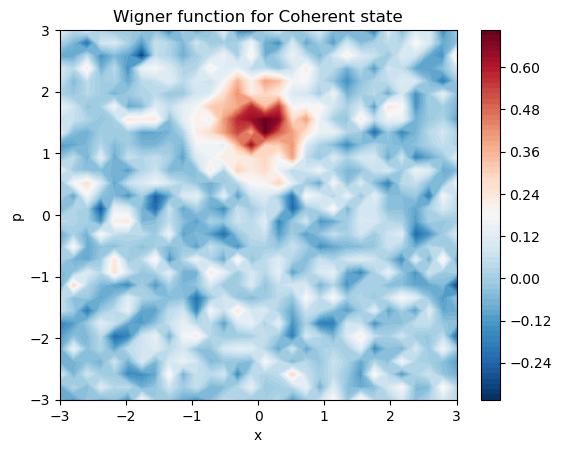

Optimal value: 4.9845635292631325
Fidelity: 0.8728580257968394
True diag:         [0.1054  0.23715 0.26679 0.2001  0.11255 0.05067 0.01894 0.0062  0.00158
 0.00063]
Reconstructed diag: [0.11031 0.18143 0.29813 0.15306 0.12292 0.05128 0.04902 0.01122 0.01597
 0.00666]


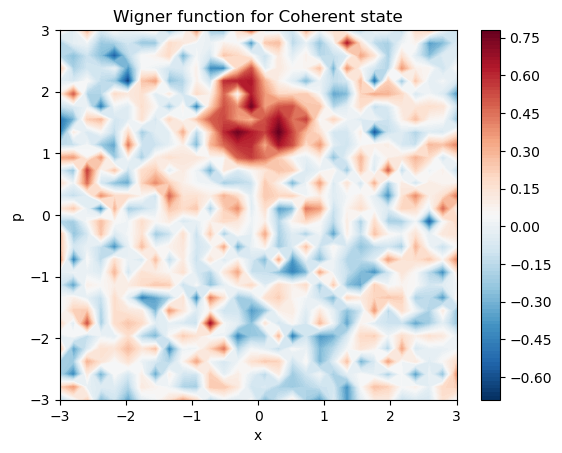

Optimal value: 22.084704347998017
Fidelity: 0.8179415451181878
True diag:         [0.1054  0.23715 0.26679 0.2001  0.11255 0.05067 0.01894 0.0062  0.00158
 0.00063]
Reconstructed diag: [0.11309 0.18266 0.25572 0.20746 0.0924  0.03707 0.02735 0.03401 0.04385
 0.00638]


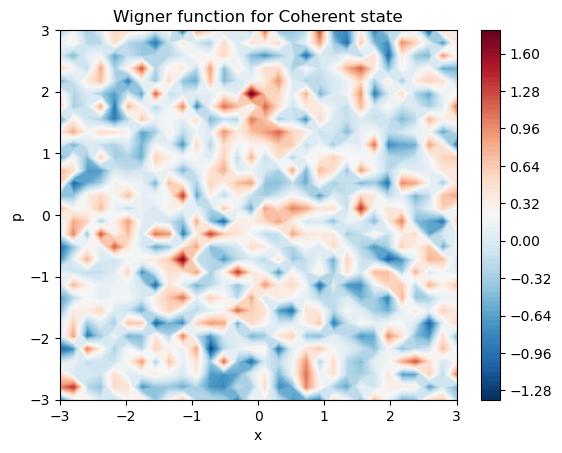

Optimal value: 135.4691190758564
Fidelity: 0.438852627629217
True diag:         [0.1054  0.23715 0.26679 0.2001  0.11255 0.05067 0.01894 0.0062  0.00158
 0.00063]
Reconstructed diag: [0.12628 0.21422 0.21491 0.14403 0.04972 0.02708 0.08814 0.01223 0.06873
 0.05468]


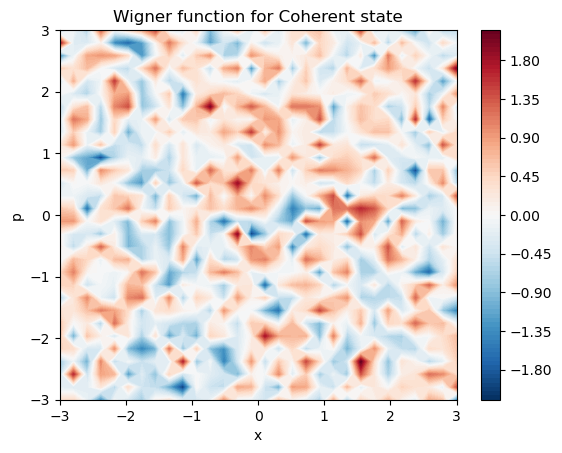

Optimal value: 263.9228473946605
Fidelity: 0.4243290063621751
True diag:         [0.1054  0.23715 0.26679 0.2001  0.11255 0.05067 0.01894 0.0062  0.00158
 0.00063]
Reconstructed diag: [0.07842 0.20239 0.26322 0.11052 0.08188 0.0459  0.02991 0.04309 0.07377
 0.07091]


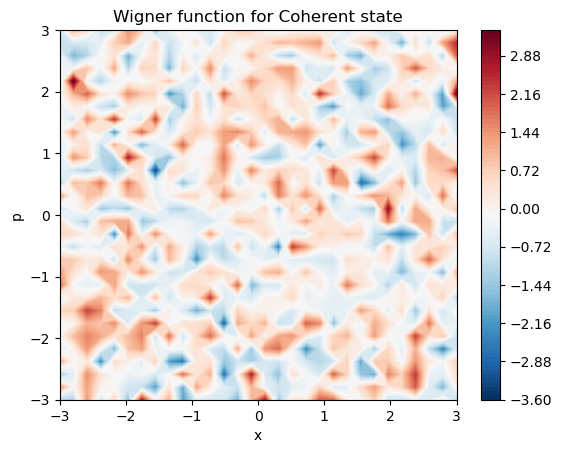

Optimal value: 555.7293316598902
Fidelity: 0.1871680072301295
True diag:         [0.1054  0.23715 0.26679 0.2001  0.11255 0.05067 0.01894 0.0062  0.00158
 0.00063]
Reconstructed diag: [0.06933 0.11825 0.04883 0.06633 0.0867  0.04914 0.11161 0.00728 0.01912
 0.42342]


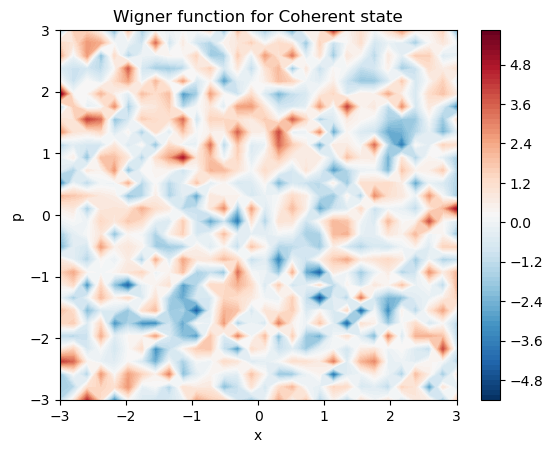

Optimal value: 1312.4463632008735
Fidelity: 0.35482724957985734
True diag:         [0.1054  0.23715 0.26679 0.2001  0.11255 0.05067 0.01894 0.0062  0.00158
 0.00063]
Reconstructed diag: [0.10351 0.16049 0.10974 0.31156 0.02282 0.03058 0.05217 0.00571 0.18393
 0.01947]


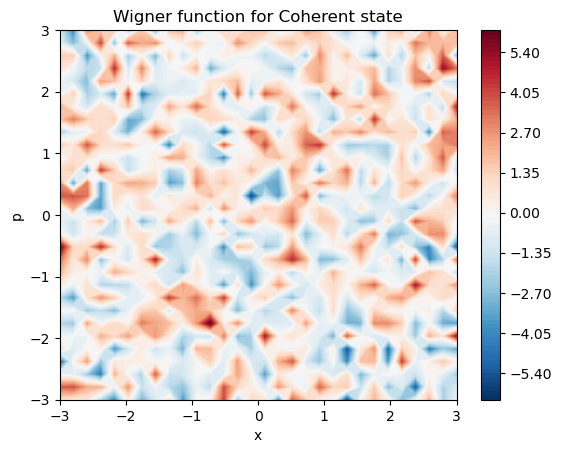

Optimal value: 2238.6948569268816
Fidelity: 0.042072399864683425
True diag:         [0.1054  0.23715 0.26679 0.2001  0.11255 0.05067 0.01894 0.0062  0.00158
 0.00063]
Reconstructed diag: [0.01609 0.03686 0.03586 0.06221 0.04942 0.1204  0.10236 0.06228 0.40782
 0.10671]


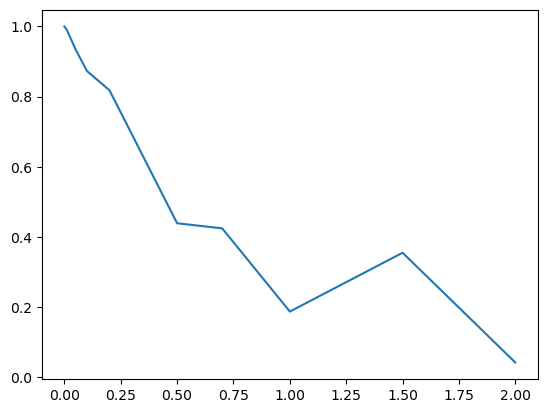

In [172]:
sigmas = [0, 0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 1, 1.5, 2]
fidelities_coherent_noise = []

for sigma in sigmas:
    psi, rho_true, data = generate_psi(10, N, 'coherent', params=1.5, noise=True, sigma=sigma)
    fidelity_coherent = fit_dm(data, rho_true, N, dim_ext=dim, dim=10)
    fidelities_coherent_noise.append(fidelity_coherent)
    
plt.plot(sigmas, fidelities_coherent_noise, label='Coherent state with noise')

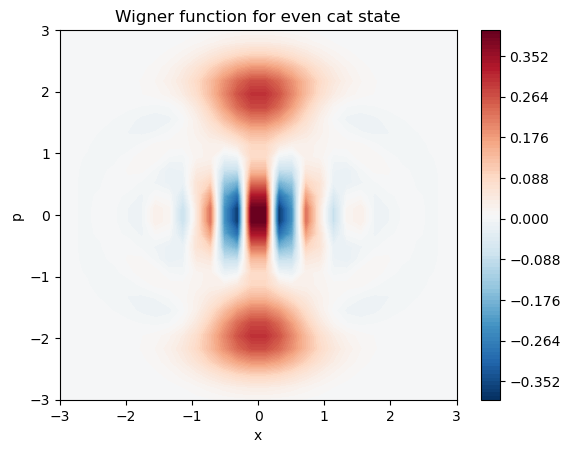

C:\Users\ZenBook\AppData\Local\Temp\ipykernel_9476\1537180879.py:35: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E = 0.5 * (dq.eye(dim) + D @ P @ dq.dag(D))


Optimal value: 0.005983569849600342
Fidelity: 0.9679673285991661
True diag:         [0.03795 0.      0.30352 0.      0.40371 0.      0.20927 0.      0.04555
 0.     ]
Reconstructed diag: [0.04049 0.00395 0.29727 0.00458 0.39489 0.00698 0.20711 0.00076 0.04255
 0.00143]


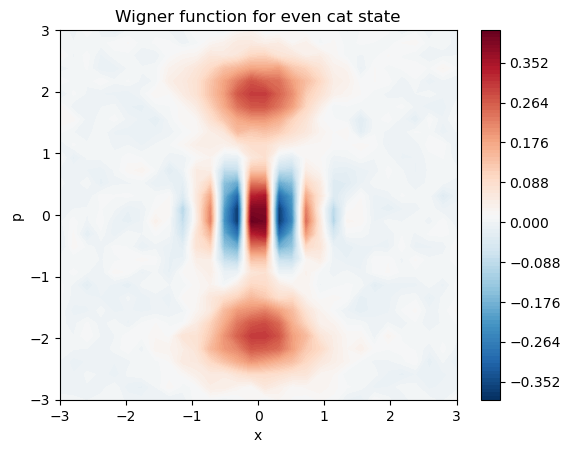

Optimal value: 0.05723249803499733
Fidelity: 0.9629036129216447
True diag:         [0.03795 0.      0.30352 0.      0.40371 0.      0.20927 0.      0.04555
 0.     ]
Reconstructed diag: [0.0418  0.00376 0.29677 0.00677 0.39    0.00624 0.20882 0.00189 0.04141
 0.00255]


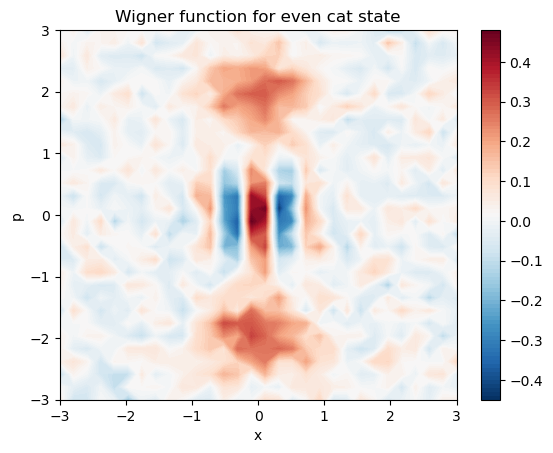

Optimal value: 1.309619116012897
Fidelity: 0.925508333584977
True diag:         [0.03795 0.      0.30352 0.      0.40371 0.      0.20927 0.      0.04555
 0.     ]
Reconstructed diag: [0.05347 0.00497 0.2986  0.00222 0.36338 0.01519 0.19646 0.00528 0.05458
 0.00586]


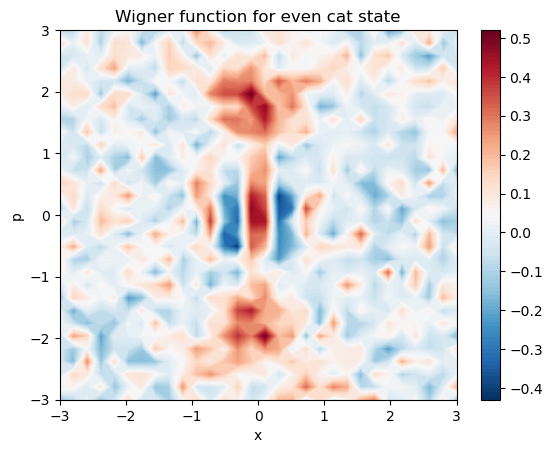

Optimal value: 5.455571915203608
Fidelity: 0.8979036165045278
True diag:         [0.03795 0.      0.30352 0.      0.40371 0.      0.20927 0.      0.04555
 0.     ]
Reconstructed diag: [0.07293 0.01215 0.29153 0.00811 0.34318 0.01927 0.17574 0.0118  0.05218
 0.01311]


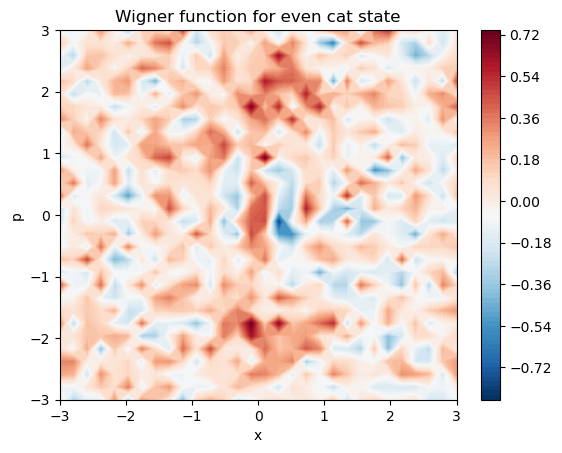

Optimal value: 20.96776724793228
Fidelity: 0.8220142682679977
True diag:         [0.03795 0.      0.30352 0.      0.40371 0.      0.20927 0.      0.04555
 0.     ]
Reconstructed diag: [0.03617 0.0128  0.31121 0.04    0.32721 0.01378 0.1882  0.0369  0.03096
 0.00276]


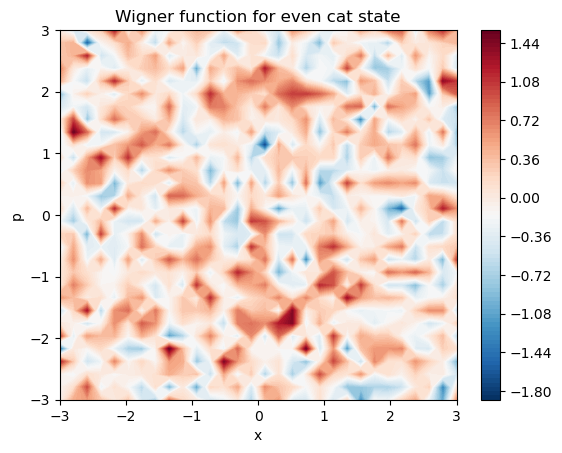

Optimal value: 140.95394765219103
Fidelity: 0.49034078272797627
True diag:         [0.03795 0.      0.30352 0.      0.40371 0.      0.20927 0.      0.04555
 0.     ]
Reconstructed diag: [0.0576  0.03283 0.2622  0.06415 0.30665 0.0657  0.11366 0.02219 0.04122
 0.0338 ]


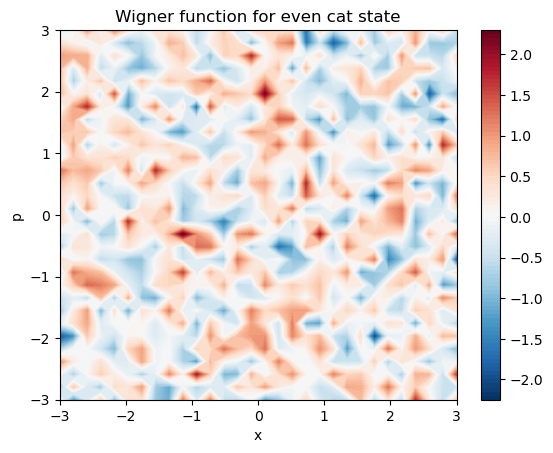

Optimal value: 257.82361056764057
Fidelity: 0.33640355187374965
True diag:         [0.03795 0.      0.30352 0.      0.40371 0.      0.20927 0.      0.04555
 0.     ]
Reconstructed diag: [0.04752 0.14228 0.1806  0.03824 0.14244 0.00812 0.08973 0.0964  0.0284
 0.22626]


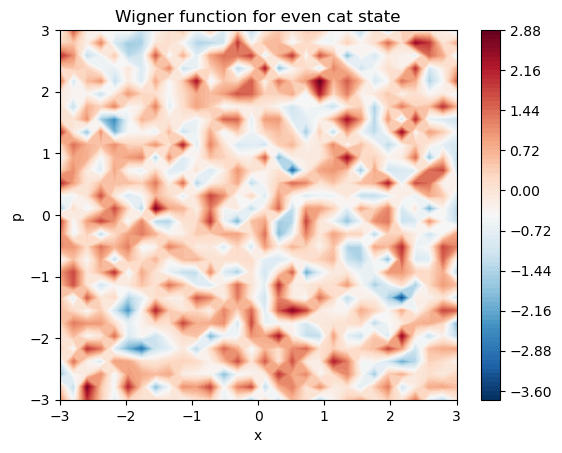

Optimal value: 528.4929924049516
Fidelity: 0.4152645948800087
True diag:         [0.03795 0.      0.30352 0.      0.40371 0.      0.20927 0.      0.04555
 0.     ]
Reconstructed diag: [0.01808 0.02372 0.03773 0.06829 0.27569 0.07043 0.25521 0.02195 0.02633
 0.20257]


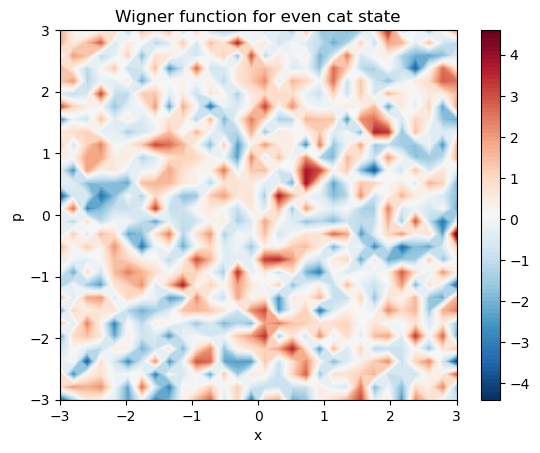

Optimal value: 1214.770543396494
Fidelity: 0.032831615318276
True diag:         [0.03795 0.      0.30352 0.      0.40371 0.      0.20927 0.      0.04555
 0.     ]
Reconstructed diag: [0.10166 0.20513 0.09287 0.14384 0.1048  0.09189 0.09396 0.054   0.06232
 0.04952]


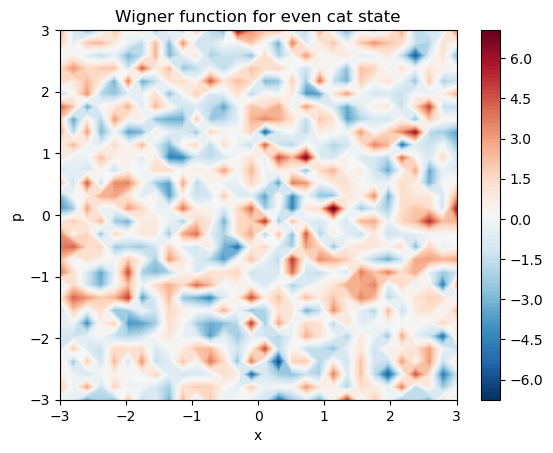

Optimal value: 2428.4613799071667
Fidelity: 0.2390057668114489
True diag:         [0.03795 0.      0.30352 0.      0.40371 0.      0.20927 0.      0.04555
 0.     ]
Reconstructed diag: [0.02969 0.2042  0.29954 0.02646 0.02005 0.0405  0.0974  0.22267 0.02549
 0.03401]


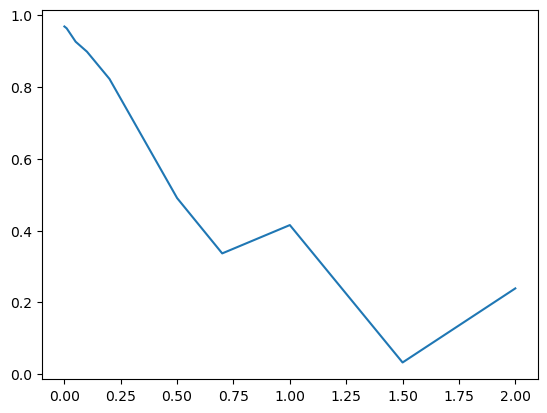

In [175]:
sigmas = [0, 0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 1, 1.5, 2]
fidelities_cat_even_noise = []

for sigma in sigmas:
    psi, rho_true, data = generate_psi(10, N, ('cat', 'even'), params=2, noise=True, sigma=sigma)
    fidelity_cat_even = fit_dm(data, rho_true, N, dim_ext=dim, dim=10)
    fidelities_cat_even_noise.append(fidelity_cat_even)
    
plt.plot(sigmas, fidelities_cat_even_noise, label='Even cat state with noise')

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
C:\Users\ZenBook\AppData\Local\Temp\ipykernel_9476\611208213.py:7: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('Gaussian noise: $\sigma$')


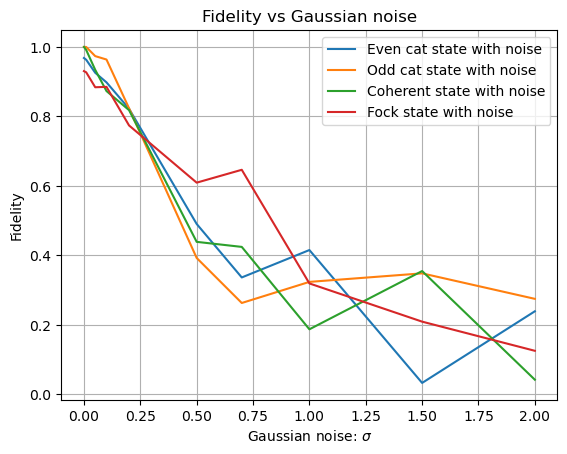

In [291]:
plt.plot(sigmas, fidelities_cat_even_noise, label='Even cat state with noise')
plt.plot(sigmas, fidelities_cat_odd_noise, label='Odd cat state with noise')
plt.plot(sigmas, fidelities_coherent_noise, label='Coherent state with noise')
plt.plot(sigmas, fidelities_fock_noise, label='Fock state with noise')

plt.legend()
plt.xlabel('Gaussian noise: $\sigma$')
plt.ylabel('Fidelity')
plt.title('Fidelity vs Gaussian noise')
plt.grid()
plt.show()

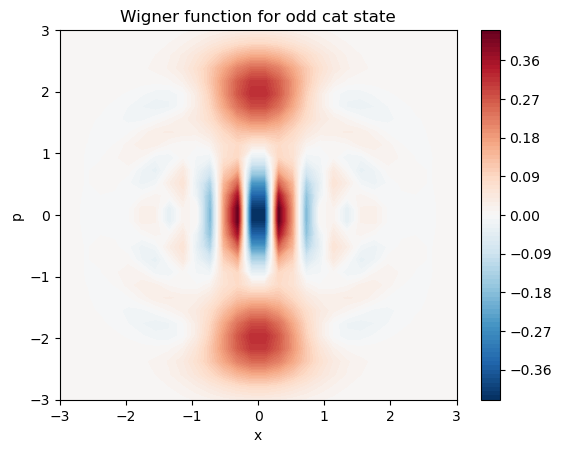

C:\Users\ZenBook\AppData\Local\Temp\ipykernel_9476\1537180879.py:35: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E = 0.5 * (dq.eye(dim) + D @ P @ dq.dag(D))


Optimal value: 0.019740174129692985
Fidelity: 0.9998818016869403
True diag:         [0.      0.14162 0.      0.3779  0.      0.30492 0.      0.12643 0.
 0.04913]
Reconstructed diag: [-0.       0.14243 -0.       0.37859 -0.       0.30556 -0.       0.12895
 -0.       0.04448]


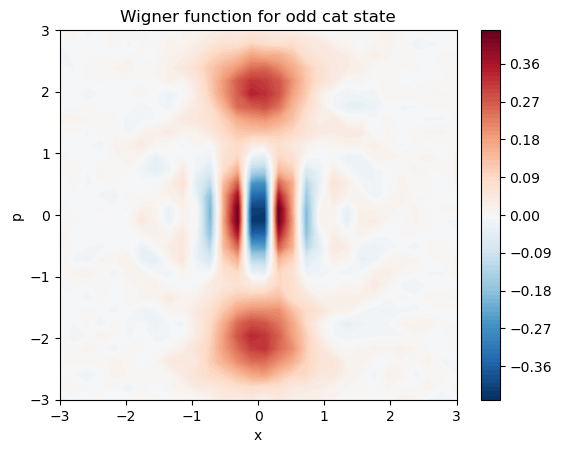

Optimal value: 0.07296676165921215
Fidelity: 0.999705300458424
True diag:         [0.      0.14162 0.      0.3779  0.      0.30492 0.      0.12643 0.
 0.04913]
Reconstructed diag: [1.0000e-05 1.4195e-01 2.0000e-05 3.7407e-01 1.0000e-05 3.0791e-01
 0.0000e+00 1.3187e-01 1.0000e-05 4.4130e-02]


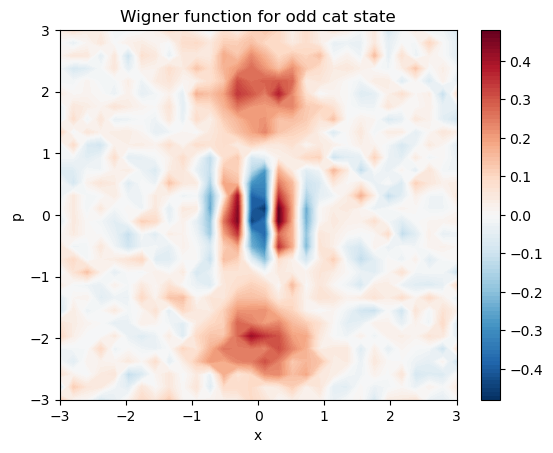

Optimal value: 1.3074101227199593
Fidelity: 0.9734382909768593
True diag:         [0.      0.14162 0.      0.3779  0.      0.30492 0.      0.12643 0.
 0.04913]
Reconstructed diag: [2.0600e-03 1.2497e-01 8.3600e-03 3.6863e-01 2.7000e-04 3.1413e-01
 3.2700e-03 1.3481e-01 4.8000e-04 4.3030e-02]


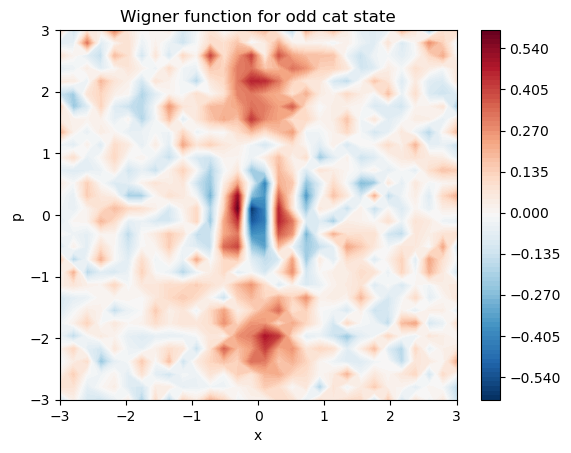

Optimal value: 5.1683794512773344
Fidelity: 0.9635953080308214
True diag:         [0.      0.14162 0.      0.3779  0.      0.30492 0.      0.12643 0.
 0.04913]
Reconstructed diag: [0.001   0.11611 0.01034 0.3803  0.0031  0.29721 0.00232 0.12026 0.00189
 0.06748]


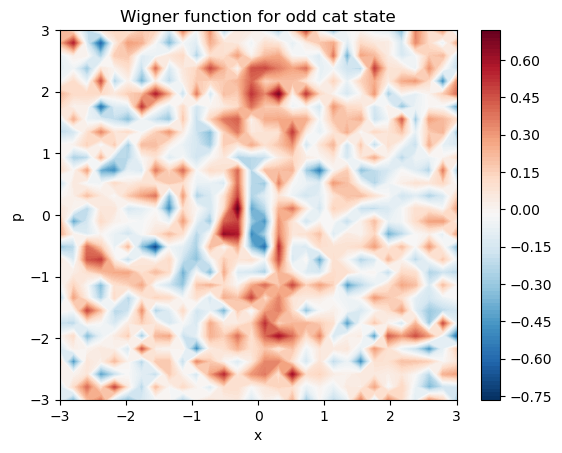

Optimal value: 21.231997435888655
Fidelity: 0.8234130662466941
True diag:         [0.      0.14162 0.      0.3779  0.      0.30492 0.      0.12643 0.
 0.04913]
Reconstructed diag: [0.02209 0.17764 0.01812 0.2923  0.01892 0.23269 0.01318 0.12053 0.03841
 0.06611]


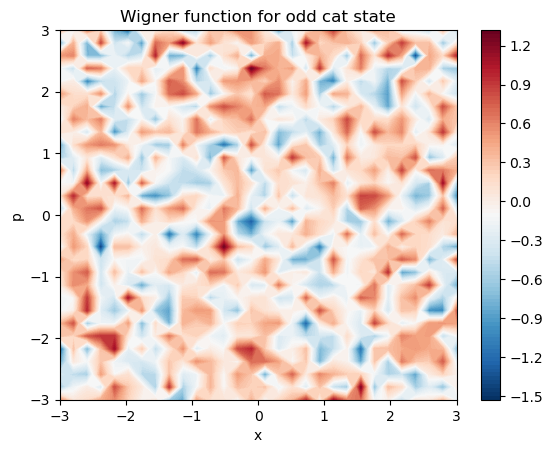

Optimal value: 122.75370737462342
Fidelity: 0.3924780410602866
True diag:         [0.      0.14162 0.      0.3779  0.      0.30492 0.      0.12643 0.
 0.04913]
Reconstructed diag: [0.02308 0.12756 0.01142 0.17192 0.14194 0.15023 0.06362 0.11887 0.12179
 0.06957]


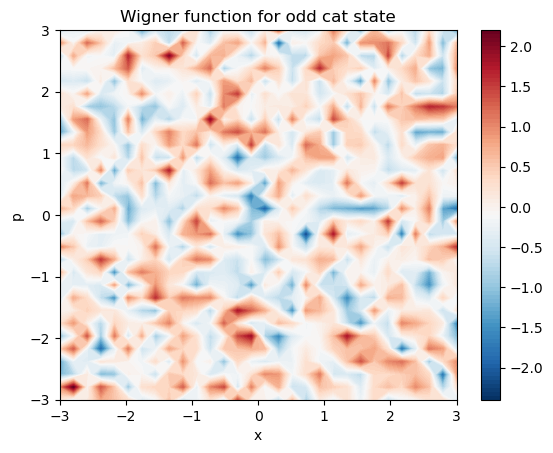

Optimal value: 267.4444884275236
Fidelity: 0.26290097978046495
True diag:         [0.      0.14162 0.      0.3779  0.      0.30492 0.      0.12643 0.
 0.04913]
Reconstructed diag: [0.01883 0.11728 0.07145 0.2584  0.20768 0.11508 0.00463 0.07451 0.03164
 0.10049]


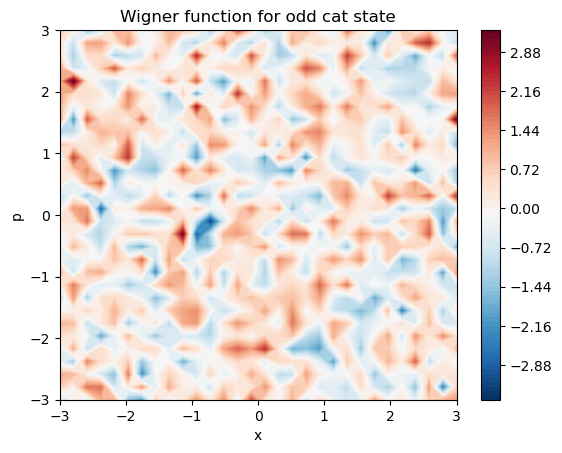

Optimal value: 521.7196545415675
Fidelity: 0.3236270050263869
True diag:         [0.      0.14162 0.      0.3779  0.      0.30492 0.      0.12643 0.
 0.04913]
Reconstructed diag: [0.02826 0.02391 0.16656 0.32421 0.04554 0.07828 0.08326 0.00704 0.1238
 0.11914]


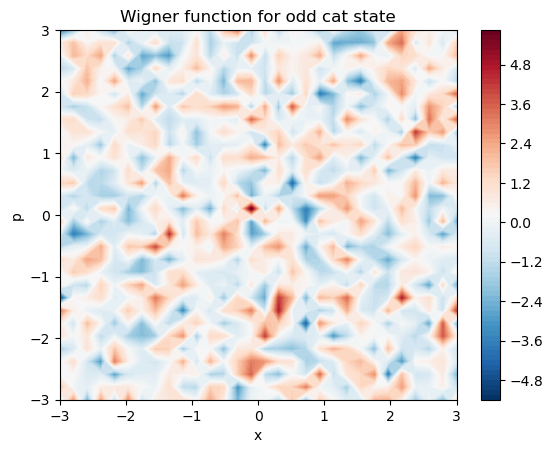

Optimal value: 1301.0789112259513
Fidelity: 0.3481789255266139
True diag:         [0.      0.14162 0.      0.3779  0.      0.30492 0.      0.12643 0.
 0.04913]
Reconstructed diag: [0.0768  0.10901 0.21269 0.25896 0.02227 0.11937 0.03773 0.05129 0.04864
 0.06323]


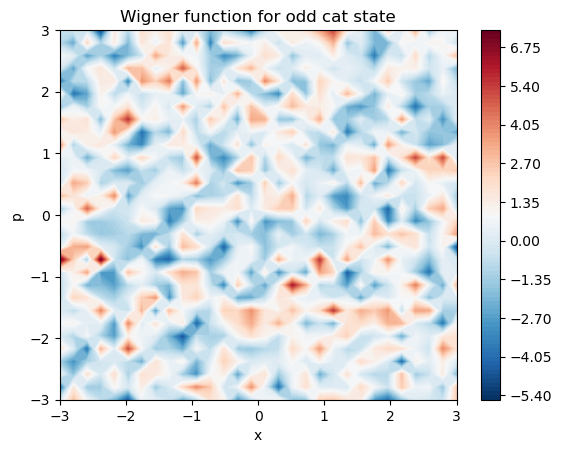

Optimal value: 2063.5520271835594
Fidelity: 0.2748144597395532
True diag:         [0.      0.14162 0.      0.3779  0.      0.30492 0.      0.12643 0.
 0.04913]
Reconstructed diag: [0.05752 0.11418 0.02945 0.14839 0.04733 0.08994 0.02759 0.25816 0.16363
 0.0638 ]


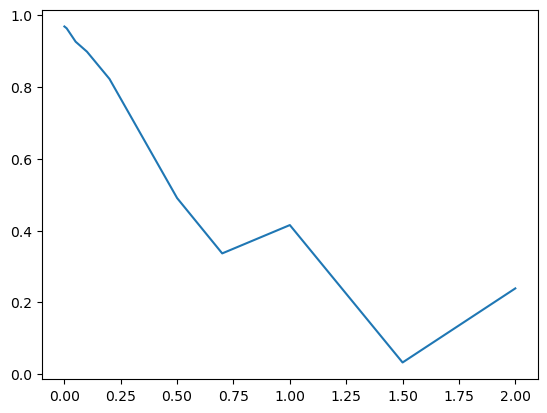

In [176]:
sigmas = [0, 0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 1, 1.5, 2]
fidelities_cat_odd_noise = []

for sigma in sigmas:
    psi, rho_true, data = generate_psi(10, N, ('cat', 'odd'), params=2, noise=True, sigma=sigma)
    fidelity_cat_odd = fit_dm(data, rho_true, N, dim_ext=dim, dim=10)
    fidelities_cat_odd_noise.append(fidelity_cat_odd)
    
plt.plot(sigmas, fidelities_cat_even_noise, label='Odd cat state with noise')

## Now try on experimental data

<>:1: SyntaxWarning: invalid escape sequence '\e'
<>:1: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ZenBook\AppData\Local\Temp\ipykernel_9476\1745275635.py:1: SyntaxWarning: invalid escape sequence '\e'
  x, y, W = pkl.load(open("data\experimental\wigner_fock_zero.pickle", 'rb'))


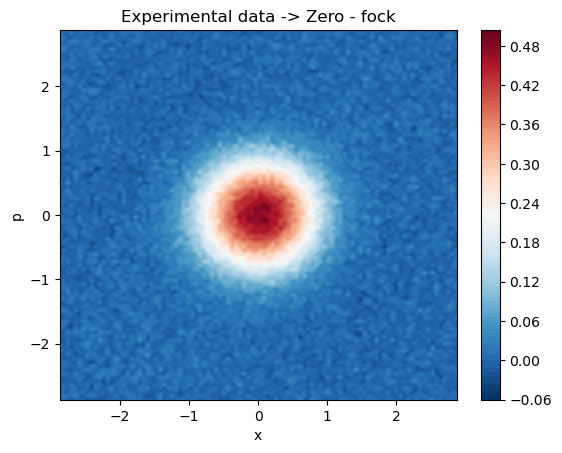

C:\Users\ZenBook\AppData\Local\Temp\ipykernel_9476\1745275635.py:1: SyntaxWarning: invalid escape sequence '\e'
  x, y, W = pkl.load(open("data\experimental\wigner_fock_zero.pickle", 'rb'))


ValueError: Cannot take a larger sample than population when replace is False

In [300]:
x, y, W = pkl.load(open("data\experimental\wigner_fock_zero.pickle", 'rb'))

plt.contourf(x, y, W, levels=100, cmap="RdBu_r")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("p")
plt.title("Experimental data -> Zero - fock")
plt.show()

rng = np.random.default_rng(seed=42)

x_inside = x[(x >= -0.15) & (x <= 0.15)]
idx_inside = np.where((x >= -0.15) & (x <= 0.15))[0]
idx_inside_selected = rng.choice(idx_inside, size=20, replace=False)

x_outside = x[(x < -0.15) | (x > 0.15)]
idx_outside = np.where((x < -0.15) | (x > 0.15))[0]
idx_outside_selected = rng.choice(idx_outside, size=20, replace=False)

# Final indices used
idx_selected = np.concatenate([idx_inside_selected, idx_outside_selected])

# Use these indices for BOTH x and y
x_selected = x[idx_selected]
y_selected = y[idx_selected]
W_selected = W[np.ix_(idx_selected, idx_selected)]
data = (x_selected, y_selected, W_selected)

plt.contourf(x_selected, y_selected, W_selected, levels=100, cmap="RdBu_r")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("p")
plt.title("Experimental data -> Zero - fock")
plt.show()


<>:1: SyntaxWarning: invalid escape sequence '\e'
<>:1: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ZenBook\AppData\Local\Temp\ipykernel_9476\2606898337.py:1: SyntaxWarning: invalid escape sequence '\e'
  x, y, W = pkl.load(open("data\experimental\wigner_fock_zero.pickle", 'rb'))


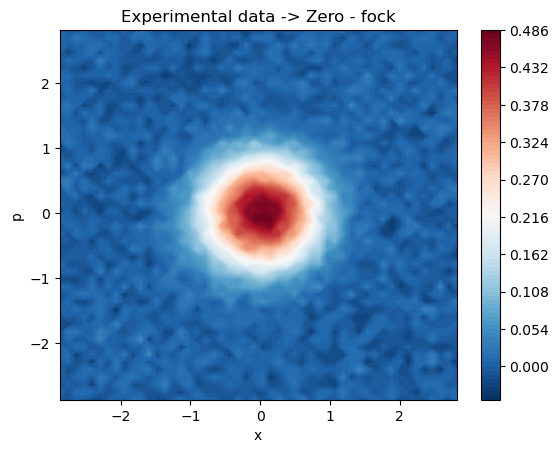

<class 'numpy.ndarray'>


In [295]:
x, y, W = pkl.load(open("data\experimental\wigner_fock_zero.pickle", 'rb'))

x_selected = x[::2]
y_selected = y[::2]
W_selected = W[::2,::2]
data = (x_selected, y_selected, W_selected)

plt.contourf(x_selected, y_selected, W_selected, levels=100, cmap="RdBu_r")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("p")
plt.title("Experimental data -> Zero - fock")
plt.show()

print(type(x_selected))

In [235]:
data = (x, y, W)

In [296]:
fit_dm(data, None, N, dim_ext=20, dim=5)

C:\Users\ZenBook\AppData\Local\Temp\ipykernel_9476\632412795.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(interp(point))  # Return scalar
C:\Users\ZenBook\AppData\Local\Temp\ipykernel_9476\632412795.py:35: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E = 0.5 * (dq.eye(dim) + D @ P @ dq.dag(D))
c:\Users\ZenBook\miniconda3\envs\alicebobhack\Lib\site-packages\cvxpy\problems\problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
c:\Users\ZenBook\miniconda3\envs\alicebobhack\Lib\site-packages\cvxpy\problems\problem.py:164: UserWarning: Constraint #0 contains too many subexpressions. Con

Optimal value: 2.032229143070883
True diag:         [8.2574e-01 4.9710e-02 8.5840e-02 1.8000e-04 3.8530e-02]


<>:1: SyntaxWarning: invalid escape sequence '\e'
<>:1: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ZenBook\AppData\Local\Temp\ipykernel_9476\344637779.py:1: SyntaxWarning: invalid escape sequence '\e'
  x, y, W = pkl.load(open("data\experimental\wigner_fock_one.pickle", 'rb'))


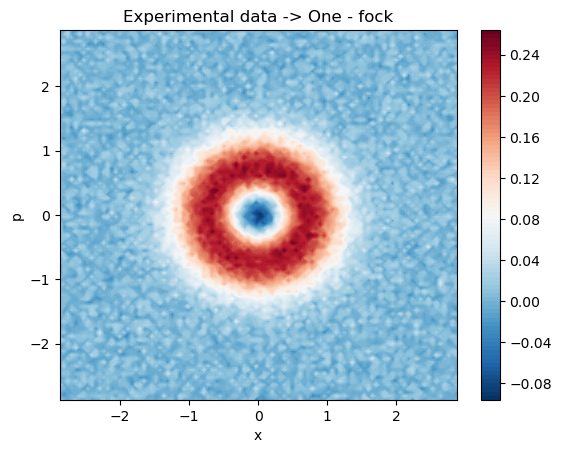

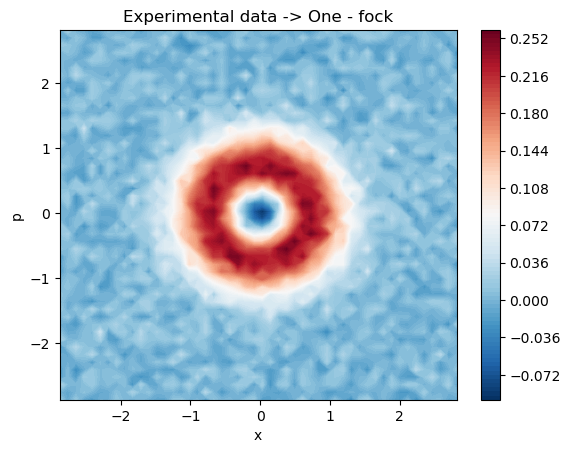

<class 'numpy.ndarray'>


In [298]:
x, y, W = pkl.load(open("data\experimental\wigner_fock_one.pickle", 'rb'))

x_selected = x[::2]
y_selected = y[::2]
W_selected = W[::2,::2]
data = (x_selected, y_selected, W_selected)

plt.contourf(x, y, W, levels=100, cmap="RdBu_r")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("p")
plt.title("Experimental data -> One - fock")
plt.show()


plt.contourf(x_selected, y_selected, W_selected, levels=100, cmap="RdBu_r")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("p")
plt.title("Experimental data -> One - fock")
plt.show()

print(type(x_selected))

In [299]:
fit_dm(data, None, N, dim_ext=20, dim=5)

C:\Users\ZenBook\AppData\Local\Temp\ipykernel_9476\632412795.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(interp(point))  # Return scalar
C:\Users\ZenBook\AppData\Local\Temp\ipykernel_9476\632412795.py:35: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E = 0.5 * (dq.eye(dim) + D @ P @ dq.dag(D))


Optimal value: 2.6556655163018963
True diag:         [0.43011 0.42498 0.06212 0.02699 0.0558 ]


<>:1: SyntaxWarning: invalid escape sequence '\e'
<>:1: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ZenBook\AppData\Local\Temp\ipykernel_9476\668502930.py:1: SyntaxWarning: invalid escape sequence '\e'
  x, y, W = pkl.load(open("data\experimental\wigner_cat_plus_25.pickle", 'rb'))


(250,)
(77,)
(250, 77)


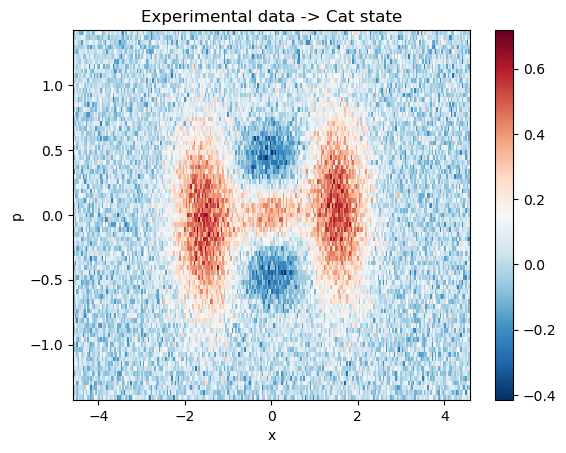

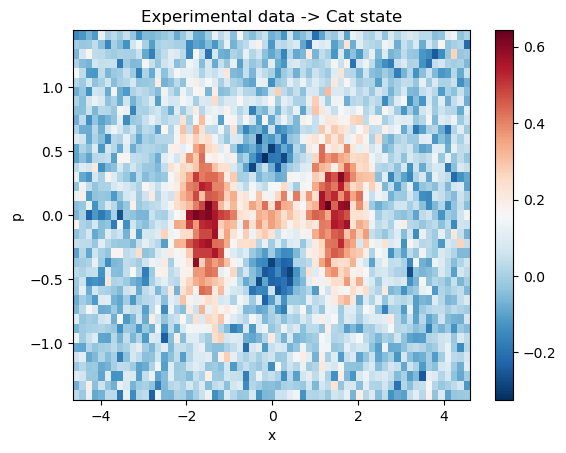

<class 'numpy.ndarray'>


In [314]:
x, y, W = pkl.load(open("data\experimental\wigner_cat_plus_25.pickle", 'rb'))

x_selected = x[::4]
y_selected = y[::2]
W_selected = W[::4,::2]
data = (x_selected, y_selected, W_selected)

print(x.shape)
print(y.shape)  
print(W.shape)

X, Y = np.meshgrid(x, y, indexing='ij')  # shapes (125, 38)
X_selected, Y_selected = np.meshgrid(x_selected, y_selected, indexing='ij')  # shapes (125, 38)

plt.pcolormesh(X, Y, W, shading='auto', cmap='RdBu_r')
plt.colorbar()
plt.title("Experimental data -> Cat state")
plt.xlabel("x")
plt.ylabel("p")
plt.show()

plt.pcolormesh(X_selected, Y_selected, W_selected, shading='auto', cmap='RdBu_r')
plt.colorbar()
plt.title("Experimental data -> Cat state")
plt.xlabel("x")
plt.ylabel("p")
plt.show()

print(type(x_selected))

In [315]:
fit_dm(data, None, N, dim_ext=30, dim=10)

ValueError: There are 63 points and 39 values in dimension 0